# I. Perkenalan

Pada project ini kita ajan menganalisa dataset mengenai gagal bayar kartu kredit. Kolom dataset tsb diantaranya adalah jumlah kredit (limit balance), gender, tingkat pendidikan, status pernikahan, umur, status pembayaran, jumlah tagihan, jumlah pembayaran dan kasus gagal bayar pada bulan berikutnya. 

Problem statement dalam laporan ini adalah untuk memprediksi kasus gagal bayar pada bulan berikutnya dengan menggunakan berbagai model machine learning, diantaranya logistic regression, support vector machine (SVM), decision tree, random forest, k-nearest neighbors, naive bayes dan algoritma lain, yaitu XGBoost. Performa model2 tsb akan dievaluasi dan dibandingkan, untuk menemukan model dengan performa terbaik.

Dataset berasal dari ml_datasets pada Big Query dengan nama credit_card_default.csv. Dataset tersebut akan diunduh menggunakan line code SQL berikut:

SELECT limit_balance, sex, education_level, marital_status, age, pay_0, pay_2, pay_3, pay_4, pay_5, pay_6, bill_amt_1, bill_amt_2, bill_amt_3, bill_amt_4, bill_amt_5, bill_amt_6, pay_amt_1, pay_amt_2, pay_amt_3, pay_amt_4, pay_amt_5, pay_amt_6, default_payment_next_month

FROM bigquery-public-data.ml_datasets.credit_card_default

LIMIT 19930

Selanjutnya, dataset di-upload ke github dan akan di-extract menggunakan platform Google Colab - Notebook.

# II. Import Libraries

Install package dan import seluruh library yg akan digunakan

In [ ]:
# Install package feature-engine untuk meng-import Winsorizer utk handling outliers
!pip install feature-engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import seluruh library yg akan digunakan
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.feature_selection import chi2
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.outliers import Winsorizer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.stats import chi2_contingency

# III. Data Loading

Loading dataset dari Github untuk selanjutnya diolah

In [ ]:
# Extract dataset dari Github dan simpan datanya ke dalam df
df = pd.read_csv('https://raw.githubusercontent.com/IrfanHilman/FTDS_Hacktiv8_Batch_16/main/h8dsft_P1M1_Irfan-Hilman.csv')

In [ ]:
# Gunakan options untuk menampilkan semua kolom
pd.options.display.max_columns = None

# Tampilkan 5 baris pertama df
df.head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,50000.0,1,3,0,50.0,0.0,0.0,0.0,-1.0,-1,-1,45771.0,23343.0,0.0,3400.0,2769.0,0.0,2266.0,0.0,3400.0,2769.0,1700.0,0.0,0
1,200000.0,2,3,0,45.0,-2.0,-2.0,-2.0,-2.0,-2,-2,399.0,2430.0,0.0,399.0,1396.0,0.0,2430.0,0.0,399.0,1396.0,0.0,0.0,0
2,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0,0,58180.0,59134.0,61156.0,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
3,230000.0,1,2,1,41.0,0.0,0.0,0.0,0.0,0,0,301038.0,305327.0,213058.0,216260.0,215968.0,174195.0,9405.0,7769.0,7757.0,8030.0,6549.0,5226.0,1
4,50000.0,1,2,1,42.0,0.0,0.0,0.0,0.0,0,2,35892.0,32546.0,30660.0,31320.0,36227.0,35569.0,2007.0,2000.0,1500.0,5400.0,0.0,3000.0,0


In [ ]:
# Tampilkan 5 baris terakhir df
df.tail()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2960,320000.0,1,2,1,41.0,1.0,-2.0,-2.0,-2.0,-2,-2,0.0,0.0,0.0,0.0,700.0,860.0,0.0,0.0,0.0,700.0,860.0,2420.0,1
2961,20000.0,1,1,1,39.0,-1.0,-1.0,-1.0,-1.0,-1,-1,628.0,662.0,596.0,630.0,664.0,598.0,700.0,600.0,700.0,700.0,600.0,1400.0,0
2962,20000.0,1,2,2,25.0,0.0,0.0,0.0,0.0,0,0,13429.0,14502.0,15564.0,16600.0,17025.0,17381.0,1300.0,1300.0,1300.0,700.0,630.0,650.0,0
2963,50000.0,1,2,2,38.0,0.0,0.0,0.0,0.0,0,0,42856.0,29248.0,17775.0,17833.0,18246.0,18642.0,1300.0,1600.0,650.0,700.0,700.0,700.0,0
2964,100000.0,2,1,2,28.0,0.0,0.0,0.0,2.0,0,0,10886.0,11697.0,14479.0,10775.0,10998.0,12655.0,1300.0,3005.0,0.0,700.0,2000.0,1500.0,0


In [ ]:
# Tampilkan ukuran df
df.shape

(2965, 24)

Terdapat 2965 baris dan 24 kolom pada df

In [ ]:
# Tampilkan nama kolom dan dtype pada df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   marital_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   int64  
 10  pay_6                       2965 non-null   int64  
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

Kolom limit_balance adalah jumlah kredit tercatat pada masing2 user. 

Sex adalah gender dgn nilai 1 = Laki2, 2 = Perempuan.

education_level adalah tingkat pendidikan user dgn nilai 1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown. 

marital_status adalah status pernikahan dgn nilai 1 = Married, 2 = Single, 3 = Others. 

age adalah umur daripada user dgn satuan tahun.

pay_n adalah status pembayaran dgn nilai -1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above. 

Ketentuan penamaan kolom adalah pay_0=status pembayaran pada bulan September 2005, pay_2=status pembayaran pada bulan Agustus 2005, pay_3=status pembayaran pada bulan Juli 2005, pay_4=status pembayaran pada bulan Juni 2005, pay_5=status pembayaran pada bulan Mei 2005, pay_6=status pembayaran pada bulan April 2005.

bill_amt adalah jumlah tagihan dgn nilai numerik. Ketentuan penamaan kolom adalah bill_amt_1 = jumlah tagihan pada bulan September 2005, bill_amt_2 = bulan Agustus 2005, bill_amt_3 = bulan Juli 2005, bill_amt_4 = bulan Juni 2005, bill_amt_5 = bulan Mei 2005, bill_amt_6 = bulan April 2005

pay_amt adalah jumlah pembayaran sebelumnya dgn nilai numerik. Ketentuan penamaan kolom adalah pay_amt_1 = jumlah pembayaran pada bulan September 2005, pay_amt_2 = bulan Agustus 2005, pay_amt_3 = bulan Juli 2005, pay_amt_4 = bulan Juni 2005, pay_amt_5 = bulan Mei 2005, pay_amt_6 = bulan April 2005

default_payment_next_month adalah kejadian gagal bayar pada nilai 1=Yes dan 0=No

# IV. Exploratory Data Analysis (EDA)

Bagian ini berisi eksplorasi data pada dataset diatas dengan menggunakan query, grouping, visualisasi sederhana, dan lain sebagainya.

Pertama2, kita ingin melihat komposisi user yg mengalami default pembayaran:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


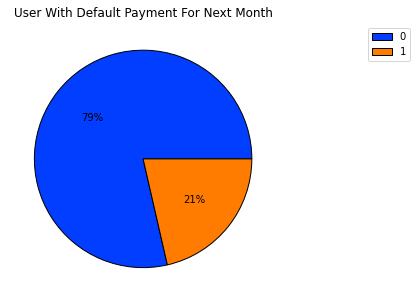

In [ ]:
# Buat label utk legend pada pie chart
palette_color = sns.color_palette('bright')
labels = list(pd.DataFrame(df['default_payment_next_month'].value_counts()).sort_index().index)

# Buat figure dan plot pie chart
plt.figure(figsize = (5, 5))
plt.title('User With Default Payment For Next Month')
plt.pie(pd.DataFrame(df['default_payment_next_month'].value_counts()),colors=palette_color, autopct='%.0f%%', wedgeprops={"edgecolor":"k"})
plt.legend(labels, loc='upper right',bbox_to_anchor=(1.5,1))

plt.show()

Dari data diatas, sebanyak 21% user mengalami default pada bulan berikutnya.

Berikutnya, kita ingin mengetahui rata2 jumlah kredit tercatat thd kemungkinan terjadinya default:

In [ ]:
# Kelompokkan data default pada bulan depan dgn rata2 jumlah kredit yg disalurkan
df.groupby('default_payment_next_month')['limit_balance'].mean()

default_payment_next_month
0    173935.622318
1    124598.425197
Name: limit_balance, dtype: float64

Bisa dilihat jika rata2 jumlah kredit tercatat pada kelompok yg mengalami default lebih rendah (124598 USD) dibandingkan pada kelompok yg tidak mengalami default (173935 USD). Hal ini bisa terjadi krn user memang memiliki penghasilan rendah atau mempunyai credit rating yg rendah sehingga tidak mampu membayar kredit dgn cara refinancing. Untuk menggali informasi lbh lanjur, mari kita lihat trend jumlah tagihan setiap bulannya pada user yg default dan tidak default:

In [ ]:
# Buat variabel bill_1 berisi rata2 tagihan per bulan utk user yg default
bill_1 = pd.DataFrame(df.loc[df['default_payment_next_month']==1, ['bill_amt_6','bill_amt_5','bill_amt_4','bill_amt_3','bill_amt_2','bill_amt_1']].mean()).rename(columns={0: "Mean"})
bill_1

,Mean
bill_amt_6,40444.259843
bill_amt_5,41617.867717
bill_amt_4,43530.267717
bill_amt_3,48099.437795
bill_amt_2,50768.069291
bill_amt_1,51292.557480


In [ ]:
# Buat variabel bill_0 berisi rata2 tagihan per bulan utk user yg tidak default
bill_0 = pd.DataFrame(df.loc[df['default_payment_next_month']==0, ['bill_amt_6','bill_amt_5','bill_amt_4','bill_amt_3','bill_amt_2','bill_amt_1']].mean()).rename(columns={0: "Mean"})
bill_0

,Mean
bill_amt_6,39590.152361
bill_amt_5,40775.722318
bill_amt_4,44242.142060
bill_amt_3,48277.999142
bill_amt_2,50616.744635
bill_amt_1,52343.348069


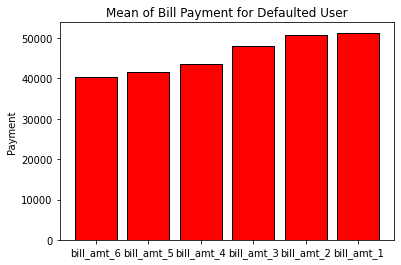

In [ ]:
# Plot diagram batang bill_1
plt.bar(bill_1.index, bill_1['Mean'], color='r', edgecolor='k')
plt.ylabel('Payment')
plt.title('Mean of Bill Payment for Defaulted User')

plt.show()


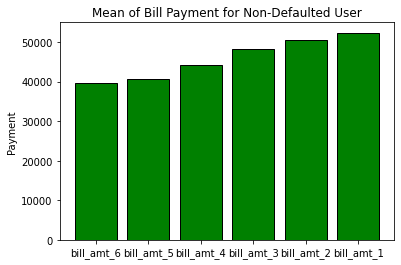

In [ ]:
# Plot diagram batang bill_0
plt.bar(bill_0.index, bill_0['Mean'], color='g', edgecolor='k')
plt.ylabel('Payment')
plt.title('Mean of Bill Payment for Non-Defaulted User')

plt.show()

Jika dilihat diatas, pada rentang bulan April-Agustus 2005 terjadi kenaikan jumlah tagihan baik pada user yg default dan non-default. Dari sini tidak ditemukan perbedaan berarti antara profil jumlah tagihan bagi user yg default dan non-default. Selanjutnya, mari kita melihat jumlah trend pembayaran per bulan bagi user yg default dan tidak default:

In [ ]:
# Buat variabel pay_1 berisi rata2 pembayaran per bulan utk user yg default
pay_1 = pd.DataFrame(df.loc[df['default_payment_next_month']==1, ['pay_amt_6','pay_amt_5','pay_amt_4','pay_amt_3','pay_amt_2','pay_amt_1']].mean()).rename(columns={0: "Mean"})
pay_1

,Mean
pay_amt_6,3166.981102
pay_amt_5,2792.908661
pay_amt_4,3195.811024
pay_amt_3,2681.051969
pay_amt_2,2994.491339
pay_amt_1,3702.329134


In [ ]:
# Buat variabel pay_0 berisi rata2 pembayaran per bulan utk user yg default
pay_0 = pd.DataFrame(df.loc[df['default_payment_next_month']==0, ['pay_amt_6','pay_amt_5','pay_amt_4','pay_amt_3','pay_amt_2','pay_amt_1']].mean()).rename(columns={0: "Mean"})
pay_0

,Mean
pay_amt_6,5986.556652
pay_amt_5,5491.157940
pay_amt_4,4933.536481
pay_amt_3,5823.500429
pay_amt_2,7165.855794
pay_amt_1,7070.179399


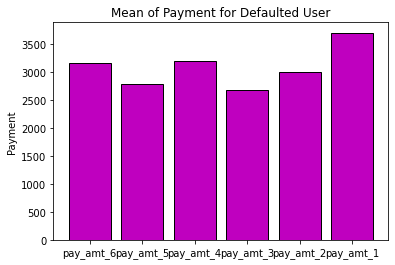

In [ ]:
# Plot diagram batang pay_1
plt.bar(pay_1.index, pay_1['Mean'], color='m', edgecolor='k')
plt.ylabel('Payment')
plt.title('Mean of Payment for Defaulted User')

plt.show()

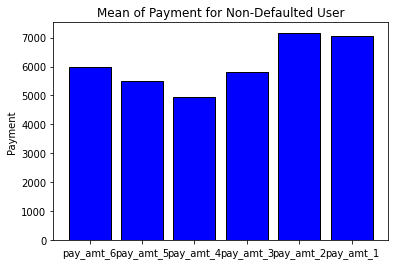

In [ ]:
# Plot diagram batang pay_0
plt.bar(pay_0.index, pay_0['Mean'], color='b', edgecolor='k')
plt.ylabel('Payment')
plt.title('Mean of Payment for Non-Defaulted User')

plt.show()

Jika dilihat dari diagram diatas, profil pembayaran cicilan pada user yg default dan non-default hampir sama. Namun bedanya, jumlah pembayaran bagi user yg default relatif lebih sedikir per bulannya dibandingkan bagi user yg tidak default. Ini artinya user yg mengalami default mengalami kesulitan pembayaran cicilan sebelum utang jatuh tempo.

Berikutnya, mari kita melihat perbedaan kecenderungan user yg default dan non-default dalam hal ketepatan waktu membayar tagihan.

In [ ]:
# Buat style matplotlib mengikuti ggplot
%matplotlib inline 
print(plt.style.available)
mpl.style.use(['ggplot']) 

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [ ]:
# Buat variabel df_00 utk menyimpan dataset pada kasus non-default
df_00 = pd.DataFrame(df.loc[df['default_payment_next_month']==0])
# Buat variabel df_11 utk menyimpan dataset pada kasus default
df_11 = pd.DataFrame(df.loc[df['default_payment_next_month']==1])

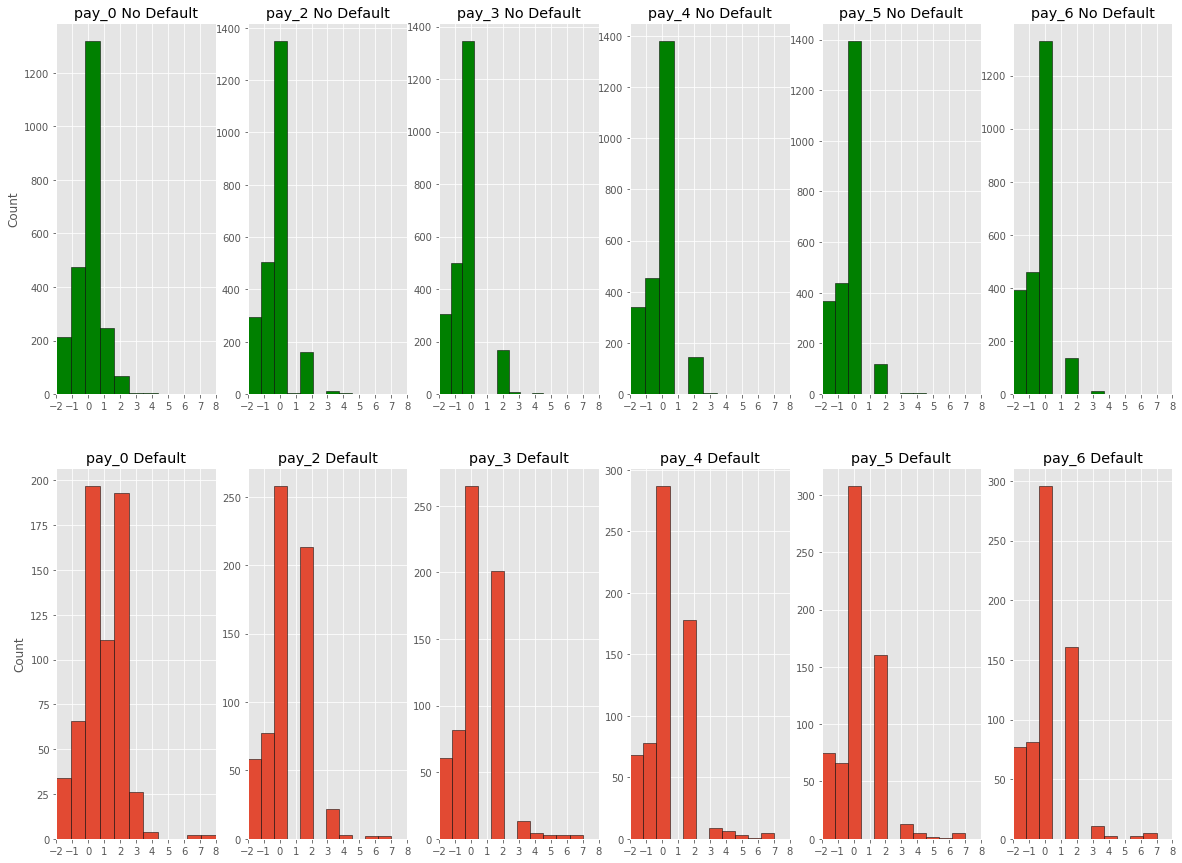

In [ ]:
# Plot dalam histogram dgn jumlah baris 2 dan kolom 6 untuk masing2 kasus pada user yg default dan non-default
fig, ax = plt.subplots(2, 6, figsize=(20, 15))
df_00['pay_0'].hist(bins=11, ax=ax[0,0], color ='g',edgecolor='k') 		
ax[0,0].set_xlim(-2,8)
ax[0,0].set_title('pay_0 No Default')	
ax[0,0].set_ylabel('Count')
ax[0,0].set_xticks(list(range(-2,9)))

df_00['pay_2'].hist(bins=11, ax=ax[0,1], color ='g', edgecolor='k') 		
ax[0,1].set_xlim(-2,8)	
ax[0,1].set_title('pay_2 No Default')	
ax[0,1].set_xticks(list(range(-2,9)))

df_00['pay_3'].hist(bins=11, ax=ax[0,2], color ='g', edgecolor='k') 		
ax[0,2].set_xlim(-2,8)	
ax[0,2].set_title('pay_3 No Default')	
ax[0,2].set_xticks(list(range(-2,9)))

df_00['pay_4'].hist(bins=11, ax=ax[0,3], color ='g', edgecolor='k') 		
ax[0,3].set_xlim(-2,8)	
ax[0,3].set_title('pay_4 No Default')	
ax[0,3].set_xticks(list(range(-2,9)))

df_00['pay_5'].hist(bins=11, ax=ax[0,4], color ='g', edgecolor='k') 		
ax[0,4].set_xlim(-2,8)	
ax[0,4].set_title('pay_5 No Default')	
ax[0,4].set_xticks(list(range(-2,9)))

df_00['pay_6'].hist(bins=11, ax=ax[0,5], color ='g', edgecolor='k') 		
ax[0,5].set_xlim(-2,8)	
ax[0,5].set_title('pay_6 No Default')	
ax[0,5].set_xticks(list(range(-2,9)))

df_11['pay_0'].hist(bins=11, ax=ax[1,0], edgecolor='k') 		
ax[1,0].set_xlim(-2,8)	
ax[1,0].set_title('pay_0 Default')	
ax[1,0].set_ylabel('Count')
ax[1,0].set_xticks(list(range(-2,9)))

df_11['pay_2'].hist(bins=11, ax=ax[1,1], edgecolor='k') 		
ax[1,1].set_xlim(-2,8)	
ax[1,1].set_title('pay_2 Default')	
ax[1,1].set_xticks(list(range(-2,9)))

df_11['pay_3'].hist(bins=11, ax=ax[1,2], edgecolor='k') 	
ax[1,2].set_xlim(-2,8)
ax[1,2].set_title('pay_3 Default')			
ax[1,2].set_xticks(list(range(-2,9)))

df_11['pay_4'].hist(bins=11, ax=ax[1,3], edgecolor='k') 		
ax[1,3].set_xlim(-2,8)	
ax[1,3].set_title('pay_4 Default')	
ax[1,3].set_xticks(list(range(-2,9)))

df_11['pay_5'].hist(bins=11, ax=ax[1,4], edgecolor='k') 		
ax[1,4].set_xlim(-2,8)
ax[1,4].set_title('pay_5 Default')		
ax[1,4].set_xticks(list(range(-2,9)))

df_11['pay_6'].hist(bins=11, ax=ax[1,5], edgecolor='k') 		
ax[1,5].set_xlim(-2,8)	
ax[1,5].set_title('pay_6 Default')	
ax[1,5].set_xticks(list(range(-2,9)))

plt.show()

Perbedaan utama antara user yg mengalami default dan non-default adalah adanya nilai label 2 lebih besar pada user yg mengalami default. Label 2 menandakan terlambat membayar selama 2 bulan. Pada user yg non-default, keterlambatan membayar juga terjadi namun intensitasnya jauh dibawah user yg default. Hal ini menandakan bahwa user yg default telah sebelumnya mengalami kesulitan finansial yg menyebabkan terlambat membayar cicilan.

Beralih dari masalah tagihan dan pembayaran cicilan, mari kita lihat profil user dalam dataset ini.

In [ ]:
# Kelompokkan rata2 jumlah kredit tercatat thd gender 
df.groupby('sex')['limit_balance'].mean()

sex
1    158925.193465
2    166237.513873
Name: limit_balance, dtype: float64

Perempuan (sex=2) mempunyai jumlah kredit tercatat lebih besar dibandingkan laki2 (sex=1). Hal ini menandakan jika perempuan dalam dataset ini lebih banyak berbelanja dgn kartu kredit dibanding laki2.

In [ ]:
# Kelompokkan rata2 jumlah kredit tercatat thd tingkat pendidikan
df.groupby('education_level')['limit_balance'].mean()

education_level
0    175000.000000
1    206025.024062
2    144964.285714
3    124409.937888
4    227692.307692
5    155416.666667
6     62500.000000
Name: limit_balance, dtype: float64

Tingkat pendidikan sedikit banyak berkorelasi dgn kecenderungan utk memakai kartu kredit. Lulusan pascasarjana (label 1) memiliki rata2 jumlah kredit tercatat yakni 206225 dimana lebih besar dibanding lulusan sarjana (label 2) yakni 144964. Namun demikian, lulusan SMA (label 3) memiliki rata2 jumlah kredit tercatat lebih rendah lagi, yaitu 124409. Untuk label2 lain tdk bisa dianalisa krn tidak bisa dikategorikan. Dari sini kita bisa menduga jika semakin tinggi pendidikan seseorang, makin besar income-nya sehingga semakin boros gaya hidupnya yg mengakibatkan org tsb cenderung menggunakan kartu kredit. Namun, krn diimbangi dgn income yg besar, jarang dari org2 berpendidikan tinggi tsb yg mengalami default. Oleh krn itu, user yg tidak mengalami default malah cenderung memiliki balance kredit lbh besar dari user yg default

Berikutnya kita akan menyelidiki tingkat pendidikan bagi pemilik kartu kredit dalam dataset ini:

In [ ]:
# Hitung jumlah user dgn masing2 tingkat pendidikan
df[['education_level']].value_counts().sort_index()

education_level
0                     2
1                  1039
2                  1400
3                   483
4                    13
5                    24
6                     4
dtype: int64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  """


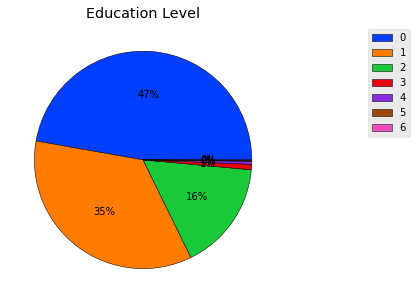

In [ ]:
# Plot persebaran tingkat pendidikan user
label1 = list(pd.DataFrame(df['education_level'].value_counts()).sort_index().index)
plt.figure(figsize = (5, 5))
plt.title('Education Level')
plt.pie(pd.DataFrame(df['education_level'].value_counts()),colors=palette_color, autopct='%.0f%%', wedgeprops={"edgecolor":"k"})
plt.legend(label1, loc='upper right',bbox_to_anchor=(1.5,1))
plt.show()

Terlihat jika sebagian besar pengguna kartu kredit adalah lulusan universitas (label 2) dan pascasarjana (label 1)

Berikutnya kita ingin melihat status pernikahan bagi para pengguna kartu kredit:

In [ ]:
# Tampilkan status pernikahan berdasarkan jumlah user
df[['marital_status']].value_counts().sort_index()

marital_status
0                    4
1                 1332
2                 1594
3                   35
dtype: int64

Terlihat jika populasi user yg masih single (label 2) lebih banyak dibanding user yg sudah menikah (label 1) pada dataset ini.

Berikutnya kita akan melakukan plot diagram box pada kolom bill_atm dan pay_atm utk melihat distribusi data secara statistik pada masing2 kolom. Kita juga akan melihat apakah banyak terdapat data outliers pada kedua kolom tsb

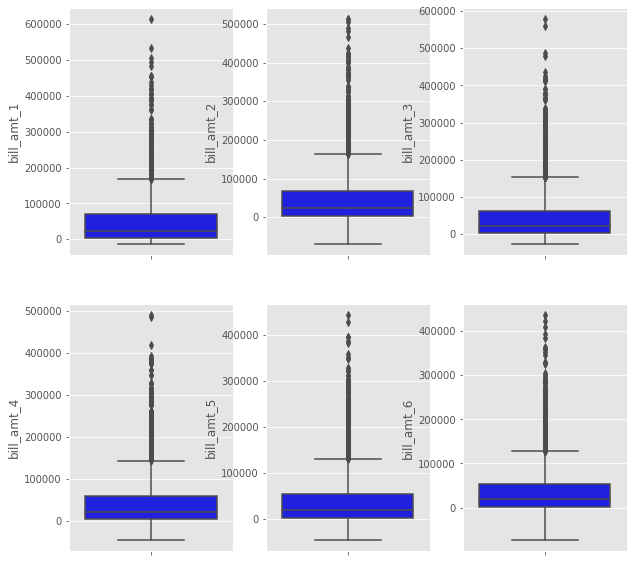

In [ ]:
# Buat diagram box pada kolom bill_atm
f, axes = plt.subplots(2, 3, figsize=(10, 10))
sns.boxplot(y="bill_amt_1", data=df, ax=axes[0,0], color='b')
sns.boxplot(y="bill_amt_2", data=df, ax=axes[0,1], color='b')
sns.boxplot(y="bill_amt_3", data=df, ax=axes[0,2], color='b')
sns.boxplot(y="bill_amt_4", data=df, ax=axes[1,0], color='b')
sns.boxplot(y="bill_amt_5", data=df, ax=axes[1,1], color='b')
sns.boxplot(y="bill_amt_6", data=df, ax=axes[1,2], color='b')
plt.show()

Pada diagram bill_atm cukup banyak outliers pada semua diagram box yg ditampilkan

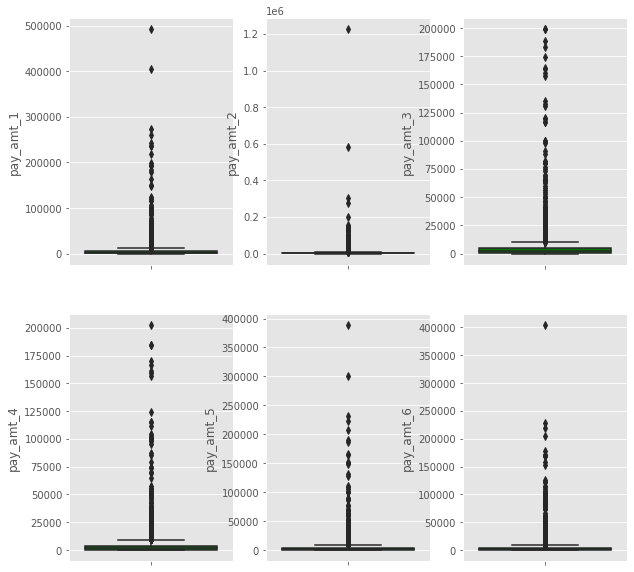

In [ ]:
# Buat diagram box pada kolom pay_atm
f, axes = plt.subplots(2, 3, figsize=(10, 10))
sns.boxplot(y="pay_amt_1", data=df, ax=axes[0,0], color='g')
sns.boxplot(y="pay_amt_2", data=df, ax=axes[0,1], color='g')
sns.boxplot(y="pay_amt_3", data=df, ax=axes[0,2], color='g')
sns.boxplot(y="pay_amt_4", data=df, ax=axes[1,0], color='g')
sns.boxplot(y="pay_amt_5", data=df, ax=axes[1,1], color='g')
sns.boxplot(y="pay_amt_6", data=df, ax=axes[1,2], color='g')
plt.show()

Pada diagram pay_atm juga cukup banyak terdapat outliers pada semua diagram box yg ditampilkan. Hanya pay_atm_2 yg memiliki relatif lebih sedikit outliers dibanding lainnya.

Keberadaan outliers2 ini akan di-capping karena cukup banyak. Proses capping akan dilakukan pada section selanjutnya.

# V. Data Preprocessing

Sebelum diproses lbh lanjut, dataset dibagi menjadi fitur (X) dan target (y). Fitur berisi kolom2 yg akan menjadi variabel independen dalam model, sedangkan target berisi satu kolom yg akan menjadi variabel dependen. Pada kolom fitur, kolom 'default_payment_next_month' dihilangkan. Lalu, dataset target akan dibuat dgn berisi kolom 'default_payment_next_month' saja.

In [ ]:
# Buat dataset fitur
X = df.drop('default_payment_next_month',axis=1)
# Buat dataset target 
y = df['default_payment_next_month']

Berikutnya lakukan train_test_split untuk membagi dataset menjadi training dan testing set dengan rasio testing set 0.3 dan aktifkan stratify pada dataset target supaya komposisi label seimbang antara training dan testing set. 

In [ ]:
# Lakukan train_test_split utk membagi dataset menjadi training (70%) dan testing set (30%). Lakukan stratify pada target agar komposisi label seimbang antara training dan test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=101)

Kemudian akan dilakukan Feature Selection dengan menentukan korelasi antara fitur kategorikal dan target. Sebelumnya, kita akan mengecek kolom kategorikal apa saja pada X_train

In [ ]:
# Tampilkan dataset fitur training
X_train.head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
1895,80000.0,2,1,2,28.0,0.0,0.0,0.0,2.0,2,0,36736.0,38079.0,40805.0,35740.0,32684.0,32605.0,1955.0,3681.0,1300.0,0.0,1500.0,1200.0
1559,100000.0,2,3,0,56.0,1.0,2.0,0.0,0.0,2,2,28625.0,27969.0,28812.0,31134.0,30444.0,32460.0,0.0,1500.0,2700.0,0.0,2400.0,0.0
2441,100000.0,2,2,2,40.0,2.0,0.0,0.0,2.0,2,2,40626.0,41945.0,45247.0,45208.0,46160.0,48268.0,2000.0,4000.0,1000.0,2000.0,3000.0,0.0
681,200000.0,1,1,1,40.0,-1.0,-1.0,-1.0,-1.0,-1,-1,840.0,770.0,386.0,0.0,475.0,390.0,800.0,396.0,4.0,475.0,1170.0,930.0
2478,170000.0,2,1,2,30.0,0.0,0.0,0.0,0.0,0,0,49341.0,49227.0,51798.0,53332.0,56303.0,59198.0,4000.0,4000.0,3000.0,4000.0,4000.0,4000.0


Fitur kategorikal berupa kolom sex, education_level dan marital_status. Fitur pay_0 - pay_6 sebenarnya juga merupakan kategorikal, tetapi fitur ini tidak akan dihilangkan krn merupakan sumber informasi penting terhadap perilaku user. Uji korelasi Chi-Square akan dilakukan untuk kolom kategorikal untuk memperoleh nilai p-value sebagai ukuran untuk menentukan ada tidaknya korelasi dgn target. Null hypothesis akan di-reject jika nilai p-value < 0.05, dengan begitu berarti cukup bukti untuk menentukan terdapat korelasi antara fitur dan target

In [ ]:
# Print hasil p-value uji Chi-Square antara masing2 variabel kategorikal dan target
csq1=chi2_contingency(pd.crosstab(y_train,X_train['sex']))
print("p-value test Chi-Square thd variabel Sex : ",csq1[1])
csq2=chi2_contingency(pd.crosstab(y_train,X_train['education_level']))
print("p-value test Chi-Square thd variabel Education Level : ",csq2[1])
csq3=chi2_contingency(pd.crosstab(y_train,X_train['marital_status']))
print("p-value test Chi-Square thd variabel Marital Status : ",csq3[1])

p-value test Chi-Square thd variabel Sex :  0.48912006646113726
p-value test Chi-Square thd variabel Education Level :  0.009974752355639339
p-value test Chi-Square thd variabel Marital Status :  0.38957491944571726


Fitur sex dan marital_status mempunyai p-value > 0.05 sehingga kedua kolom tsb akan dihapus.

In [ ]:
# Delete kolom sex dan marital_statu dari dataset X_train dan X_test. Store dataset hasil feature selection ke X_train_fs dan X_test_fs
X_train_fs = X_train.drop(['sex','marital_status'], axis=1)
X_test_fs = X_test.drop(['sex','marital_status'], axis=1)

Berikutnya akan dilakukan proses handling outliers menggunakan fungsi Winsorizer. Fungsi ini akan melakukan capping dengan metode di-set sebagai IQR, dgn alasan karena distribusi data tidaklah Gaussian ketika di-plot ke dalam box diagram (lihat EDA). Metode capping dipilih karena jumlah outliers cukup banyak sehingga memerlukan metode untuk meng-handle tanpa harus menghapus data ouliers tsb

In [ ]:
# Lakukan pendefinisian model capping dgn metode IQR dan tail kedua sisi menggunakan Winsorizer
windsoriser = Winsorizer(capping_method='iqr', #Metode IQR diterapkan krn berdasarkan bentuk boxplot bentuk data tdk menyerupai Gaussian
                          tail='both', 
                          fold=1.5)

# Fitting winsorizer ke dataset X_train_fs
windsoriser.fit(X_train_fs)
 
# Transformasi dataset X_train_fs dan X_test_fs menggunakan windsoriser
X_train_fs_ho = windsoriser.transform(X_train_fs)
X_test_fs_ho = windsoriser.transform(X_test_fs)

Mari kita bandingkan distribusi kolom pay_amt sebelum dan sesudah capping:

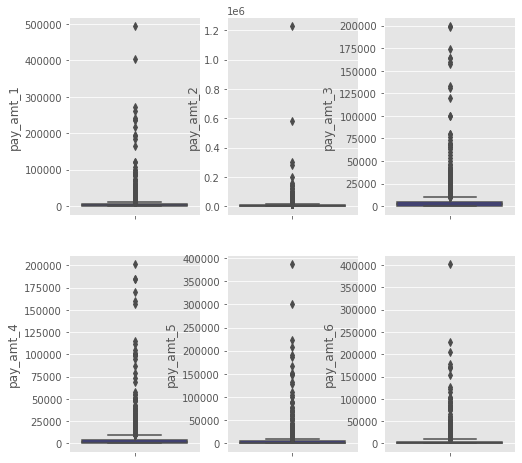

In [ ]:
# Plot diagram box untuk kolom pay_amt_1 sampai pay_amt6 sebelum handling outliers dgn metode capping dilakukan
f, axes = plt.subplots(2, 3, figsize=(8, 8))
sns.boxplot(y="pay_amt_1", data=X_train_fs, ax=axes[0,0], color='b')
sns.boxplot(y="pay_amt_2", data=X_train_fs, ax=axes[0,1], color='b')
sns.boxplot(y="pay_amt_3", data=X_train_fs, ax=axes[0,2], color='b')
sns.boxplot(y="pay_amt_4", data=X_train_fs, ax=axes[1,0], color='b')
sns.boxplot(y="pay_amt_5", data=X_train_fs, ax=axes[1,1], color='b')
sns.boxplot(y="pay_amt_6", data=X_train_fs, ax=axes[1,2], color='b')
plt.show()

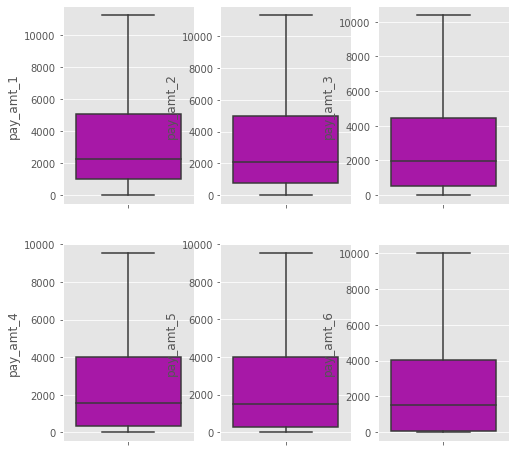

In [ ]:
# Plot diagram box untuk kolom pay_amt_1 sampai pay_amt6 setelah handling outliers 
f, axes = plt.subplots(2, 3, figsize=(8, 8))
sns.boxplot(y="pay_amt_1", data=X_train_fs_ho, ax=axes[0,0], color='m')
sns.boxplot(y="pay_amt_2", data=X_train_fs_ho, ax=axes[0,1], color='m')
sns.boxplot(y="pay_amt_3", data=X_train_fs_ho, ax=axes[0,2], color='m')
sns.boxplot(y="pay_amt_4", data=X_train_fs_ho, ax=axes[1,0], color='m')
sns.boxplot(y="pay_amt_5", data=X_train_fs_ho, ax=axes[1,1], color='m')
sns.boxplot(y="pay_amt_6", data=X_train_fs_ho, ax=axes[1,2], color='m')
plt.show()

Terlihat jika tidak terdapat data outliers yg dianalisa dalam box diagram. Berikutnya, kita akan melakukan proses imputasi, scaling dan encoding menggunakan pipeline. Proses imputasi dan scaling dilakukan thd data numerik. Proses encoding dilakukan thd data kategorikal. Proses imputasi menggunakan SimpleImputer dgn strategy median, artinya missing values akan diganti oleh nilai median. Proses scaling menggunakan MinMaxScaler krn distribusi data adalah skewed. Proses encoding pada data kategorikal menggunakan OneHotEncoder (OHE) krn dapat mentransformasi label menjadi 0 atau 1, sehingga tidak mengakibatkan pembobotan saat nilai2 tsb diproses dalam modelling.

In [ ]:
# Buat variabel numeric_features berisi nama kolom2 numerik
numeric_features = ['limit_balance', 'age','bill_amt_1','bill_amt_2','bill_amt_3','bill_amt_4','bill_amt_5','bill_amt_6',
                    'pay_amt_1','pay_amt_2','pay_amt_3','pay_amt_4','pay_amt_5','pay_amt_6']
# Buat pipeline dgn nama numeric_transformer berisi step imputasi dan scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  #SimpleImputer digunakan utk imputasi nilai missing values dan menggantinya dgn nilai median
    ('scaler', MinMaxScaler())])  #MinMaxScaler digunakan untuk scaling krn berdasarkan boxplot terlihat jika bentuk distribusi data numerik adlh skewed

# Buat variabel categorical_features berisi nama kolom2 kategorikal
categorical_features = ['education_level','pay_0','pay_2','pay_3','pay_4','pay_5','pay_6']
# Buat pipeline dgn nama numeric_transformer berisi step encoding
categorical_transformer = OneHotEncoder(handle_unknown='ignore')  #OHE digunakan untuk encoding nilai kategorikal menjadi 0 atau 1. 
                                                                  #Penggunaan bilangan biner ini berguna untuk menghilangkan pembobotan seperti pada OrdinalEncoder atau LabelEncoder


Berikutnya, pipeline untuk data numerik dan kategorikal disatukan dalam fungsi ColumnTransformer yg di-assign ke dalam variabel preprocessor. Fungsi ColumnTransformer akan melakukan preprocessing data numerik dan kategorik secara sekaligus dgn membedakan treatment pada masing2 jenis data.

In [ ]:
# Buat variabel preprocessor berisi fungsi ColumnTransformer utk melakukan preprocessing data numerik dan kategorik secara terpisah
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# VI. Model Definition

Pendefinisian model akan dilakukan satu per satu pada masing2 model. Kemudian model tsb akan dimasukkan ke dalam pipeline bersama variabel preprocessor, agar data dapat menjalani proses preprocessing lalu training model secara berurutan. Masing2 model (kecuali Gaussian Naive Bayes) akan menggunakan bbrp kombinasi nilai hyperparameter. Dari kombinasi tsb akan dicari hyperparameter yg memberikan performance model terbaik. Proses optimasi ini menggunakan GridSearchCV. Kelebihan dari grid search dibandingkan random search adalah seluruh kombinasi hyperparameter akan diuji satu per satu, lalu kombinasi hyperparameter yg terbaik akan dipilih.

LOGISTIC REGRESSION

Model Logistic Regression di-definisikan sebagai log. 

In [ ]:
# Mendefinisikan model Logistic Regression ke dalam variabel log
log = LogisticRegression(random_state = 101)

Berikutnya, model Logistic Regression dimasukkan ke dalam pipeline

In [ ]:
# Buat pipeline berisi step preprocessing (preprocessor) lalu step Logistic Regression (log). Pipeline disimpan ke dalam variabel clf_log
clf_log = Pipeline(steps=[('preprocessor', preprocessor),
                      ('log', LogisticRegression())])


Hyperparameter ditentukan sebagai penalty : l2 atau none, dan max_iter : 1000. Penalty menentukan regularisasi pada model regresi. l2 adalah ridge regularization. l1 (Lasso) tidak digunakan krn tidak terdapat pada model Logistic Regression. None berarti model regresi tdk dikenakan regularisasi. Sedangkan max_iteration menentukan maksimum batas iterasi yg dilakukan. Nilai max_iteration harus dinaikkan diatas nilai default utk mencegah error.

In [ ]:
# Buat variabel param_log berisi hyperparameter beserta value yang hendak dioptimasi 
param_log = {'log__penalty' : ['l2','none'],'log__max_iter' : [1000]}

Proses grid search dilakukan pada pipeline clf_log berdasarkan kombinasi hyperparameter yg telah di-set. Angka cross-validation di-set di angka 5 (cv=5), artinya terdapat 5 fold validation set untuk menguji tingkat keabsahan model sebelum model diuji pada testing dataset.

In [ ]:
# Buat variabel grid_log berisi fungsi GridSearchCV untuk mencari hyperparameter dgn nilai optimal pada Logistic Regression. Set nilai cross-validation = 5
grid_log = GridSearchCV(clf_log, param_log, cv=5)

SUPPORT VECTOR MACHINE

Alur proses utk model2 lain sama dgn model Logistic Regression. Berikutnya, model Support Vector Classifier (SVC) dimasukkan ke dalam variabel svm.

In [ ]:
# Mendefinisikan model SVC ke dalam variabel svc
svm = SVC(random_state = 101)

Model dimasukkan ke dalam pipeline

In [ ]:
# Buat pipeline berisi step preprocessing (preprocessor) lalu step SVC (svm). Pipeline disimpan ke dalam variabel clf_svm
clf_svm = Pipeline(steps=[('preprocessor', preprocessor),
                      ('svm', SVC())])

Penentuan hyperparameter utk SVC adalah C=0.1, 1, 10; gamma: 0,1, 1, 10; kernel: rbf, linear, poly. C adalah hyperparameter utk regularisasi. Semakin besar nilai C, maka margin (jarak antara data point ke hyperplane) akan semakin kecil. Gamma menentukan seberapa banyak data point yg dapat mempengaruhi hyperplane. Semakin besar gamma, akan semakin sedikit data point yg dapat mempengaruhi hyperplane, sehingga hanya data point di sekitar hyperplane saja yg memiliki pengaruh. Kedua hyperparameter ini dipilih krn sangat penting dalam menentukan bentuk dan orientasi hyperplane. Sedangkan kernel merupakan fungsi untuk menentukan bentuk dan metode pemisahan oleh hyperplane. Kernel linear memiliki hyperplane linear dan polynomial memiliki hyperplane non-linear. Kernel rbf akan mentransformasi data ke dalam dimensi lebih tinggi sehingga persebaran data berbentuk lingkaran dapat dipisahkan.

In [ ]:
# Buat variabel param_svm berisi hyperparameter beserta value yang hendak dioptimasi 
param_svm = {'svm__C': [0.1, 1, 10],
              'svm__gamma': [0.1, 1, 10],
             'svm__kernel': ['rbf','linear','poly']}

Lakukan optimasi hyperparameter grid search menggunakan cross-validation 5.

In [ ]:
# Buat variabel grid_svm berisi fungsi GridSearchCV untuk mencari hyperparameter dgn nilai optimal pada model SVC. Set nilai cross-validation = 5
grid_svm = GridSearchCV(clf_svm, param_grid=param_svm, cv=5)

DECISION TREE

Berikutnya, model Decision Tree dimasukkan ke dalam variabel dtc

In [ ]:
# Mendefinisikan model Decision Tree ke dalam variabel dtc
dtc = DecisionTreeClassifier(random_state = 101)

Model dimasukkan ke dalam pipeline

In [ ]:
# Buat pipeline berisi step preprocessing (preprocessor) lalu step Decision Tree (dtc). Pipeline disimpan ke dalam variabel clf_dtc
clf_dtc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('dtc', DecisionTreeClassifier())])

Hyperparameter untuk model Decision Tree ditentukan sebagai Criterion: Gini, Entropy dan max_depth: range antara 5 dan 100 dgn step 5. Criterion menentukan fitur yg digunakan saat pohon melakukan proses splitting. Criterion Gini berarti pohon akan memilih fitur berdasarkan Gini Index terendah. Criterion Entropy berarti pohon akan memilih fitur berdasarkan pertambahan informasi yg dihitung dari selisih nilai entropi. Criterion dipilih karena sangat menentukan strategi pohon dalam membuat keputusan. Sedangkan max_depth adalah jarak antara root dan leaf terakhir. Max_depth berguna utk membatasi tingkat percabangan pohon sehingga model dapat di-running secara lbh efisien.

In [ ]:
# Buat variabel param_dtc berisi hyperparameter beserta value yang hendak dioptimasi 
param_dtc = {'dtc__criterion':['gini','entropy'],'dtc__max_depth':list(range(5,101,5))}

Lakukan optimasi hyperparameter grid search menggunakan cross-validation 5.

In [ ]:
# Buat variabel grid_dtc berisi fungsi GridSearchCV untuk mencari hyperparameter dgn nilai optimal pada model Decision Tree. Set nilai cross-validation = 5
grid_dtc = GridSearchCV(clf_dtc, param_grid=param_dtc, cv=5)

RANDOM FOREST

Berikutnya, model Random Forest dimasukkan ke dalam variabel rfc.

In [ ]:
# Mendefinisikan model Random Forest ke dalam variabel rfc
rfc = RandomForestClassifier(random_state = 101)

Model dimasukkan ke dalam pipeline

In [ ]:
# Buat pipeline berisi step preprocessing (preprocessor) lalu step Random Forest (rfc). Pipeline disimpan ke dalam variabel clf_rfc
clf_rfc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rfc', RandomForestClassifier())])

Hyperparameter untuk model Random Forest ditentukan sebagai Criterion: gini, entropy, max_depth: 5, 10 ; n_estimators: 50, 100. Random Forest terdiri dari banyak pohon Decision Tree. Jumlah pohon tsb dapat di-set oleh n_estimators. Banyak pohon dapat memperbaiki performance model, namun memperlama computation time. Sehingga hyperparameter n_estimators akan dioptimasi pada laporan ini. Alasan penggunaan hyperparameter criterion dan max_depth sama dengan model Decision Tree.

In [ ]:
# Buat variabel param_rfc berisi hyperparameter beserta value yang hendak dioptimasi 
param_rfc = { 
    'rfc__n_estimators': [50, 100],
    'rfc__max_depth' : [5,10],
    'rfc__criterion' :['gini', 'entropy']}

Lakukan optimasi hyperparameter grid search menggunakan cross-validation 5.

In [ ]:
# Buat variabel grid_rfc berisi fungsi GridSearchCV untuk mencari hyperparameter dgn nilai optimal pada model Random Forest. Set nilai cross-validation = 5
grid_rfc = GridSearchCV(clf_rfc, param_grid=param_rfc, cv=5)

K-NEAREST NEIGHBORS

Berikutnya, model k-Nearest Neighbors dimasukkan ke dalam variabel knn.

In [ ]:
# Mendefinisikan model k-Nearest Neighbors ke dalam variabel knn
knn = KNeighborsClassifier()

Model dimasukkan ke dalam pipeline

In [ ]:
# Buat pipeline berisi step preprocessing (preprocessor) lalu step K-Nearest Neighbors (knn). Pipeline disimpan ke dalam variabel clf_knn
clf_knn = Pipeline(steps=[('preprocessor', preprocessor),
                      ('knn', KNeighborsClassifier())])

Hyperparameter yg akan di-tuning adalah n_neighbors dgn range 1-20. n_neighbors dipilih krn menentukan jumlah tetangga terdekat pada data point baru yg ingin di-klasifikasi sehingga berpengaruh besar pada decision boundary. 

In [ ]:
# Buat variabel param_knn berisi hyperparameter beserta value yang hendak dioptimasi 
param_knn = {'knn__n_neighbors': list(range(1,21))}

Lakukan optimasi hyperparameter grid search menggunakan cross-validation 5.

In [ ]:
# Buat variabel grid_knn berisi fungsi GridSearchCV untuk mencari hyperparameter dgn nilai optimal pada K-Nearest Neighbors. Set nilai cross-validation = 5
grid_knn = GridSearchCV(clf_knn, param_grid=param_knn, cv=5)

GAUSSIAN NAIVE BAYES

Model Gaussian Naive Bayes dimasukkan ke dalam variabel gnb.

In [ ]:
# Mendefinisikan model Gaussian Naive Bayes ke dalam variabel gnb
gnb = GaussianNB()

Model Gaussian Naive Bayes tdk melalui proses hyperparameter tuning krn tidak memiliki hyperparameter utk dioptimasi. Selanjutnya, model langsung dimasukkan ke dalam pipeline

In [ ]:
# Buat pipeline berisi step preprocessing (preprocessor) lalu step Gaussian Naive Bayes (gnb). Pipeline disimpan ke dalam variabel clf_gnb
clf_gnb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('gnb', GaussianNB())])

XGBOOST

Model XGBoost dimasukkan ke dalam variabel xbs. Model XGBoost dipilih sebagai algoritma machine learning alternatif dalam laporan ini krn: 

1. Model ini sangat populer di kompetisi Kaggle dan dunia industri

2. XGBoost menggunakan algoritma gradient boosting utk problem klasifikasi dan regresi serta memiliki performance cukup baik dan computing time cukup cepat dibanding model2 sejenis

In [ ]:
# Mendefinisikan model XGBoost ke dalam variabel xgb
xbs = xgb.XGBClassifier(random_state = 101)

Model dimasukkan ke dalam pipeline

In [ ]:
# Buat pipeline berisi step preprocessing (preprocessor) lalu step XGBoost (xbs). Pipeline disimpan ke dalam variabel clf_xbs
clf_xbs = Pipeline(steps=[('preprocessor', preprocessor),
                      ('xbs', xgb.XGBClassifier())])

Hyperparameter yg akan di-tuning adalah max_depth dgn range 2-10 dan step 2; min_child_weight dgn range 2-10 dan step 2; learning_rate : 0.1, 0.2. max_depth adalah tingkat kedalaman pohon, sama halnya dgn pohon pada model Decision Tree. learning_rate adalah kecepatan model XGBoost dalam belajar. Parameter ini menentukan jumlah pohon baru yg ditambahkan kepada model utk mengkoreksi error dari urutan pohon sebelumnya. Semakin kecil learning_rate, diperlukan semakin banyak pohon baru utk ditambahkan. Hasilnya performance model dapat semakin bagus namun computation time semakin lama

In [ ]:
# Buat variabel param_xbs berisi hyperparameter beserta value yang hendak dioptimasi 
param_xbs = {'xbs__max_depth': list(range(2,11,2)),
             'xbs__learning_rate': [0.1,0.2]}

Lakukan optimasi hyperparameter grid search menggunakan cross-validation 5.

In [ ]:
# Buat variabel grid_xbs yg berisi fungsi GridSearchCV untuk mencari hyperparameter dgn nilai optimal pada XGBoost. Set nilai cross-validation = 5
grid_xbs = GridSearchCV(clf_xbs, param_grid=param_xbs, cv=5)

# VII. Model Training

Pada bagian ini, masing2 model akan di-training pada dataset training fitur dan target. Kemudian, model hasil training akan digunakan untuk memprediksi dataset training dan testing fitur. Supaya analisa semakin lengkap, perbandingan antara based model dgn model hasil tuning hyperparameter (tuned model) akan disajikan



# Base Model

Base model akan dibuat menggunakan pipeline masing2 model tanpa melalui grid search. Base model ini selanjutnya akan digunakan utk memprediksi training set dan test set.

In [ ]:
base_log = clf_log.fit(X_train_fs_ho, y_train)

In [ ]:
y_base_pred_train_log = base_log.predict(X_train_fs_ho)
y_base_pred_test_log = base_log.predict(X_test_fs_ho)

In [ ]:
base_svm = clf_svm.fit(X_train_fs_ho, y_train)

In [ ]:
y_base_pred_train_svm = base_svm.predict(X_train_fs_ho)
y_base_pred_test_svm = base_svm.predict(X_test_fs_ho)

In [ ]:
base_dtc = clf_dtc.fit(X_train_fs_ho, y_train)

In [ ]:
y_base_pred_train_dtc = base_dtc.predict(X_train_fs_ho)
y_base_pred_test_dtc = base_dtc.predict(X_test_fs_ho)

In [ ]:
base_rfc = clf_rfc.fit(X_train_fs_ho, y_train)

In [ ]:
y_base_pred_train_rfc = base_rfc.predict(X_train_fs_ho)
y_base_pred_test_rfc = base_rfc.predict(X_test_fs_ho)

In [ ]:
base_knn = clf_knn.fit(X_train_fs_ho, y_train)

In [ ]:
y_base_pred_train_knn = base_knn.predict(X_train_fs_ho)
y_base_pred_test_knn = base_knn.predict(X_test_fs_ho)

In [ ]:
base_xbs = clf_xbs.fit(X_train_fs_ho, y_train)

In [ ]:
y_base_pred_train_xbs = base_xbs.predict(X_train_fs_ho)
y_base_pred_test_xbs = base_xbs.predict(X_test_fs_ho)

# Tuned Model

Pada bagian ini, model akan melalui grid search untuk mencari hyperparameter terbaik. Proses pemodelan adalah training model pada training set fitur dan target, lalu prediksi.

LOGISTIC REGRESSION 

Training model Logistic Regression pada training set fitur dan target

In [ ]:
# Tampilkan CPU time dan Wall time
%%time
# Training model Logistic Regression dlm bentuk grid pipeline pada dataset training hasil feature selection dan handling outliers serta dataset target
grid_log.fit(X_train_fs_ho, y_train)

CPU times: user 1.8 s, sys: 1.33 s, total: 3.13 s
Wall time: 1.7 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['limit_balance',
                                                                          'age',
                                                                          'bill_amt_1',
                                                                          'bill_amt_2',
                                                              

Prediksi model Logistic Regression hasil training pada fitur set training dan testing

In [ ]:
# Prediksi nilai target pada training set dan testing set menggunakan model Logistic Regression hasil training
y_pred_train_log = grid_log.best_estimator_.predict(X_train_fs_ho)
y_pred_test_log = grid_log.best_estimator_.predict(X_test_fs_ho)

SUPPORT VECTOR MACHINE

Training model SVC pada training set fitur dan target

In [ ]:
%%time
# Training model SVC dlm bentuk grid pipeline pada dataset training hasil feature selection dan handling outliers serta dataset target
grid_svm.fit(X_train_fs_ho, y_train)

CPU times: user 5min 49s, sys: 338 ms, total: 5min 49s
Wall time: 6min 5s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['limit_balance',
                                                                          'age',
                                                                          'bill_amt_1',
                                                                          'bill_amt_2',
                                                              

Prediksi model SVC hasil training pada fitur set training dan testing

In [ ]:
# Prediksi nilai target pada training set dan testing set menggunakan model SVC hasil training
y_pred_train_svm = grid_svm.best_estimator_.predict(X_train_fs_ho)
y_pred_test_svm = grid_svm.best_estimator_.predict(X_test_fs_ho)

DECISION TREE

Training model Decision Tree pada training set fitur dan target

In [ ]:
%%time
# Training model Decision Tree dlm bentuk grid pipeline pada dataset training hasil feature selection dan handling outliers serta dataset target
grid_dtc.fit(X_train_fs_ho, y_train)

CPU times: user 11.9 s, sys: 40.9 ms, total: 11.9 s
Wall time: 12 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['limit_balance',
                                                                          'age',
                                                                          'bill_amt_1',
                                                                          'bill_amt_2',
                                                              

Prediksi model Decision Tree pada training dan testing set fitur 

In [ ]:
# Prediksi nilai target pada training set dan testing set menggunakan model Decision Tree hasil training
y_pred_train_dtc = grid_dtc.best_estimator_.predict(X_train_fs_ho)
y_pred_test_dtc = grid_dtc.best_estimator_.predict(X_test_fs_ho)

RANDOM FOREST

Training model Random Forest pada training set fitur dan target

In [ ]:
%%time
# Training model Random Forest dlm bentuk grid pipeline pada dataset training hasil feature selection dan handling outliers serta dataset target
grid_rfc.fit(X_train_fs_ho, y_train)

CPU times: user 12.8 s, sys: 40.8 ms, total: 12.9 s
Wall time: 13 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['limit_balance',
                                                                          'age',
                                                                          'bill_amt_1',
                                                                          'bill_amt_2',
                                                              

Prediksi model Random Forest pada training dan testing set fitur 

In [ ]:
# Prediksi nilai target pada training set dan testing set menggunakan model Random Forest hasil training
y_pred_train_rfc = grid_rfc.best_estimator_.predict(X_train_fs_ho)
y_pred_test_rfc = grid_rfc.best_estimator_.predict(X_test_fs_ho)

K-NEAREST NEIGHBORS

Training model KNN pada training set fitur dan target

In [ ]:
%%time
# Training model k-Nearest Neigbors dlm bentuk grid pipeline pada dataset training hasil feature selection dan handling outliers serta dataset target
grid_knn.fit(X_train_fs_ho, y_train)

CPU times: user 7.74 s, sys: 5.69 s, total: 13.4 s
Wall time: 6.89 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['limit_balance',
                                                                          'age',
                                                                          'bill_amt_1',
                                                                          'bill_amt_2',
                                                              

Prediksi model KNN pada training dan testing set fitur 

In [ ]:
# Prediksi nilai target pada training set dan testing set menggunak4an model k-Nearest Neighbors hasil training
y_pred_train_knn = grid_knn.best_estimator_.predict(X_train_fs_ho)
y_pred_test_knn = grid_knn.best_estimator_.predict(X_test_fs_ho)

GAUSSIAN NAIVE BAYES 

Training model Gaussian Naive Bayes pada training set fitur dan target

In [ ]:
%%time
# Training model Gaussian Naive Bayes pada dataset training hasil feature selection dan handling outliers serta dataset target. Store model hasil training ke dalam model_gnb
gnb_model = clf_gnb.fit(X_train_fs_ho, y_train)

CPU times: user 26.6 ms, sys: 17 ms, total: 43.6 ms
Wall time: 27.1 ms


Prediksi model Gaussian Naive Bayes pada training dan testing set fitur 

In [ ]:
# Prediksi nilai target pada training set dan testing set menggunakan model Gaussian Naive Bayes hasil training
y_pred_train_gnb = gnb_model.predict(X_train_fs_ho)
y_pred_test_gnb = gnb_model.predict(X_test_fs_ho)

XGBOOST

Training model XGBoost pada training set fitur dan target

In [ ]:
%%time
# Training model XG Boost dlm bentuk grid pipeline pada dataset training hasil feature selection dan handling outliers serta dataset target
grid_xbs.fit(X_train_fs_ho, y_train)

CPU times: user 26.6 s, sys: 122 ms, total: 26.7 s
Wall time: 26.8 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['limit_balance',
                                                                          'age',
                                                                          'bill_amt_1',
                                                                          'bill_amt_2',
                                                              

Prediksi model XGBoosr pada training dan testing set fitur

In [ ]:
# Prediksi nilai target pada training set dan testing set menggunakan model XGBoost hasil training
y_pred_train_xbs = grid_xbs.best_estimator_.predict(X_train_fs_ho)
y_pred_test_xbs = grid_xbs.best_estimator_.predict(X_test_fs_ho)

Selanjutnya untuk mengukur dan membandingkan computation time masing2 model yg melalui hyperparameter tuning dibuatlah tabel berisi kolom CPU Time dan Wall Time

In [ ]:
# Buat tabel berisi list CPU time dan Wall time pada proses training masing2 model
pd.DataFrame({'CPU Time' : ['1.8s','5min 49s','11.9s','12.8s','7.74s','26.6 ms','26.6s'],
              'Wall Time': ['1.7s','6min 5s','12s','13s','6.89s','27.1 ms','26.8s'],
                                        }, index=['Logistic Regression','SVM',
                                                   'Decision Tree',
                                                   'Random Forest',
                                                   'K-Nearest Neighbors','Gaussian Naive Bayes',
                                                   'XGBoost'])

,CPU Time,Wall Time
Logistic Regression,1.8s,1.7s
SVM,5min 49s,6min 5s
Decision Tree,11.9s,12s
Random Forest,12.8s,13s
K-Nearest Neighbors,7.74s,6.89s
Gaussian Naive Bayes,26.6 ms,27.1 ms
XGBoost,26.6s,26.8s


Secara keseluruhan, algoritma Gaussian Naive Bayes mempunyai running time paling cepat (CPU = 26.6 ms, Wall = 27.1). Namun, hal ini dikarenakan fungsi grid search tidak diterapkan pada algoritma ini. Jika memperhitungkan tuning hyperparameter menggunakan grid search, model Logistic Regression mempunyai running time tercepat (CPU = 1.8s, Wall = 1.7s). Hal ini dikarenakan Logistic Regression merupakan model paling sederhana dibandingkan model machine learning lainnya. Selain itu, tuning hanya dilakukan pada parameter penalty. Model dgn running time terlama adalah SVM (CPU = 5min 49s, Wall = 6min 5s) dikarenakan terdapat 3 hyperparameter (C, gamma, kernel) dan 3 value utk masing2 hyperparameter tsb utk di-tuning, sehingga menghasilkan 27 kombinasi.

# VIII. Model Evaluation

Pada bagian ini, dilakukan evaluasi model utk menunjukkan bagaimana performa model berdasarkan metrics yang dipilih. Hal ini dibuktikan dengan visualisasi tren performa dan/atau tingkat kesalahan model.

Pertama, kita akan melihat kombinasi hyperparameter terbaik setelah proses tuning menggunakan grid search.

In [ ]:
# Print hasil hyperparameter terbaik untuk model Logistic Regression berdasarkan grid search
print("Hyperparameter terbaik untuk Logistic Regression adalah: {}".format(grid_log.best_params_))

Hyperparameter terbaik untuk Logistic Regression adalah: {'log__max_iter': 1000, 'log__penalty': 'l2'}


Ridge regularization (l2) meningkatkan performance model Logistic Regression pada kasus ini, dibandingkan tanpa regularisasi.

In [ ]:
# Print hasil hyperparameter terbaik untuk model SVC berdasarkan grid search
print("Hyperparameter terbaik untuk SVM adalah: {}".format(grid_svm.best_params_))

Hyperparameter terbaik untuk SVM adalah: {'svm__C': 1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


Kernel rbf dgn C=1 dan Gamma =0.1 adalah hyperparameter terbaik utk SVM. Berarti persebaran data berbentuk lingkaran sehingga lebih baik utk dipisahkan menggunakan decision boundary stlh data ditransform menuju dimensi lbh besar oleh kernel rbf. Gamma harus di-set dgn angka kecil (0.1) krn nilai gamma besar membuat decision boundary terlalu terkonsentrasi pada cluster tertentu.

In [ ]:
# Print hasil hyperparameter terbaik untuk model Decision Tree berdasarkan grid search
print("Hyperparameter terbaik untuk Decision Tree adalah: {}".format(grid_dtc.best_params_))

Hyperparameter terbaik untuk Decision Tree adalah: {'dtc__criterion': 'entropy', 'dtc__max_depth': 5}


Kriteria entropy dgn kedalaman maksimum pohon adlh 5 adlh hyperparameter terbaik utk model Decision Tree. Hal ini berarti pohon dpt mengambil keputusan lbh baik menggunakan kriteria information gain dari tingkat keacakan informasi. Sedangkan kedalaman maksimum 5 menandakan model tdk memerlukan struktur percabangan pohon yg terlalu kompleks utk memberikan hasil terbaik.

In [ ]:
# Print hasil hyperparameter terbaik untuk model Random Forest berdasarkan grid search
print("Hyperparameter terbaik untuk Random Forest adalah: {}".format(grid_rfc.best_params_))

Hyperparameter terbaik untuk Random Forest adalah: {'rfc__criterion': 'gini', 'rfc__max_depth': 10, 'rfc__n_estimators': 100}


Kriteria gini dgn kedalaman max pohon adlh 10 dan n_estimators 100 adlh kombinasi hyperparameter terbaik utk Random Forest. Dalam hal kriteria, Random Forest berbeda dari Decision Tree krn menggunakan kriteria gini bagi pohon utk melakukan decision. Kriteria gini berarti pohon akan memutuskan fitur berdasarkan angka gini index yg mengukur probabilitas salah klasifikasi pada suatu fitur. Fitur dgn gini index yg lebih rendah akan dijadikan cabang bagi pohon. Kedalaman pohon (max_depth) lbh besar dibanding model Decision Tree dan n_estimators menandakan perlu 100 pohon dalam Random Forest utk menghasilkan model terbaik. Namun secara trade-off,semakin dalam pohon dan semakin banyak jumlah pohon bisa meningkatkan resiko overfitting pada training set dan computation time lbh lama. 

In [ ]:
# Print hasil hyperparameter terbaik untuk model KNN berdasarkan grid search
print("Hyperparameter terbaik untuk K-Nearest Neighbor adalah: {}".format(grid_knn.best_params_))

Hyperparameter terbaik untuk K-Nearest Neighbor adalah: {'knn__n_neighbors': 14}


Jumlah tetangga terbaik utk model KNN adalah 14 dari range 1-20. 

In [ ]:
# Print hasil hyperparameter terbaik untuk model XGBoost berdasarkan grid search
print("Hyperparameter terbaik untuk XGBoost adalah: {}".format(grid_xbs.best_params_))

Hyperparameter terbaik untuk XGBoost adalah: {'xbs__learning_rate': 0.1, 'xbs__max_depth': 2}


Hyperparameter terbaik utk XGBoost adlh learning rate = 0.1 dan max kedalaman pohon = 2. Max kedalaman pohon ini tdk lebih dalam dari model Decision Tree dan Random Forest, menandakan algoritma XGBoost dapat lbh efisien dibandingkan kedua model tsb. Umumnya, semakin kecil learning rate akan menghasilkan performance lebih baik, namun hal tsb juga akan meningkatkan computing time.

Selanjutnya, kita buat tabel mengenai accuracy score training dan testing set model2 dgn hyperparameter terbaik 

In [ ]:
# Buat tabel mengenai summary hyperparameter terbaik masing2 model beserta skor accuracy pada training dan testing set
summary_table = pd.DataFrame({'Best Hyperparameter': ['max_iter=1000,penalty=l2','C=1, gamma=0.1, kernel=rbf','criterion=entropy, max_depth=5',
                                      'criterion=gini, max_depth=10, n_estimators=100','n_neighbors=14','',
                                      'learning_rate=0.1, max_depth=2'],
              'Accuracy Score (Train-Base)': [accuracy_score(y_train,y_base_pred_train_log), accuracy_score(y_train,y_base_pred_train_svm),
                                        accuracy_score(y_train,y_base_pred_train_dtc), accuracy_score(y_train,y_base_pred_train_rfc),
                                        accuracy_score(y_train,y_base_pred_train_knn), '',
                                        accuracy_score(y_train,y_base_pred_train_xbs)], 
              'Accuracy Score (Test-Base)': [accuracy_score(y_test,y_base_pred_test_log), accuracy_score(y_test,y_base_pred_test_svm),
                                       accuracy_score(y_train,y_base_pred_train_dtc), accuracy_score(y_test,y_base_pred_test_rfc),
                                       accuracy_score(y_test,y_base_pred_test_knn), '',
                                       accuracy_score(y_test,y_base_pred_test_xbs)],
              'Accuracy Score (Train-Tuned)': [accuracy_score(y_train,y_pred_train_log), accuracy_score(y_train,y_pred_train_svm),
                                        accuracy_score(y_train,y_pred_train_dtc), accuracy_score(y_train,y_pred_train_rfc),
                                        accuracy_score(y_train,y_pred_train_knn), accuracy_score(y_train,y_pred_train_gnb),
                                        accuracy_score(y_train,y_pred_train_xbs)], 
              'Accuracy Score (Test-Tuned)': [accuracy_score(y_test,y_pred_test_log), accuracy_score(y_test,y_pred_test_svm),
                                       accuracy_score(y_test,y_pred_test_dtc), accuracy_score(y_test,y_pred_test_rfc),
                                       accuracy_score(y_test,y_pred_test_knn), accuracy_score(y_test,y_pred_test_gnb),
                                       accuracy_score(y_test,y_pred_test_xbs)
                                        ]}, index=['Logistic Regression','SVM', 'Decision Tree','Random Forest',
                                                   'K-Nearest Neighbors','Gaussian Naive Bayes', 'XGBoost'])
# Pilih option untuk menampilkan maksimum lebar kolom = 80 agar semua isi kolom terbaca
pd.set_option('display.max_colwidth',80)
summary_table

,Best Hyperparameter,Accuracy Score (Train-Base),Accuracy Score (Test-Base),Accuracy Score (Train-Tuned),Accuracy Score (Test-Tuned)
Logistic Regression,"max_iter=1000,penalty=l2",0.836145,0.839326,0.836145,0.839326
SVM,"C=1, gamma=0.1, kernel=rbf",0.849639,0.835955,0.842892,0.834831
Decision Tree,"criterion=entropy, max_depth=5",0.999518,0.999518,0.853012,0.815730
Random Forest,"criterion=gini, max_depth=10, n_estimators=100",0.999518,0.829213,0.914217,0.828090
K-Nearest Neighbors,n_neighbors=14,0.85494,0.821348,0.839518,0.821348
Gaussian Naive Bayes,,,,0.304096,0.321348
XGBoost,"learning_rate=0.1, max_depth=2",0.873735,0.840449,0.851084,0.837079


Secara keseluruhan performance model sudah cukup baik pada training dan testing set dgn skor akurasi > 0.8, kecuali Gaussian Naïve Bayes (GNB) dimana hanya mempunyai skor akurasi ~0.3. Buruknya performa GNB bisa dikarenakan bbrp factor: GNB mengasumsikan setiap kelas memiliki distribusi Gaussian dimana distribusi sebenarnya adalah skewed (lihat boxplot). Selain itu, GNB lebih cocok diterapkan pada data continuous (numerik), sedangkan beberapa kolom pada dataset ini berisi data kategorikal. Ditambah lagi, GNB tidak menjalani cross-validation dan tidak terdapat hyperparameter utk di-tuning. 

Base model dgn skor akurasi terbaik adalah Decision Tree dgn skor hampir sempurna (0.99). Namun keabsahan skor ini sangatlah diragukan krn berada diatas Random Forest. Ditambah lagi, skor utk model tsb pada hasil tuning jauh lebih rendah disbanding base model, dimana hal sb cukup aneh. Proses model inference akan dilakukan untuk mengetahui validity skor tsb.

Secara keseluruhan, base model memiliki skor akurasi lbh baik dibandingkan model dgn hyperparameter tuning, kecuali untuk Logistic Regression dan SVM dimana performance kedua model kurang lebih sama. Namun, base model belum tentu lebih baik dibandingkan model dgn hyperparameter tuning setelah kita melakukan uji model inference. Kondisi overfitting juga terlihat dari table secara keseluruhan karena skor akurasi pada testing set lebih rendah dibanding pada training set pada base model dan tuned model.


Berikutnya, kita akan menampilkan hasil confusion matrix dan classification report pada masing2 model. Confusion matrix berisi jumlah true positive (TP), true negative (TN), false positive (FP) dan false negative (FN) yg di-plot dalam bentuk matrix utk mempermudah visualisasi. Sedangkan classification report berisi nilai precision, recall dan f-1 score masing2 label beserta nilai macro-average dan weighted-average dari model. 

LOGISTIC REGRESSION

Confusion matrix utk Logistic Regression pada hasil prediksi training set:

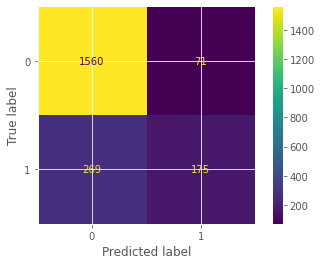

In [ ]:
# Buat confusion matrix untuk hasil prediksi Logistic Regression dgn hyperparameter terbaik menggunakan training set
cm_train_log = confusion_matrix(y_train,y_pred_train_log, labels=grid_log.best_estimator_.classes_)
disp_train_log = ConfusionMatrixDisplay(confusion_matrix=cm_train_log, display_labels=grid_log.best_estimator_.classes_)

# Tampilkan confusion matrix
disp_train_log.plot()
plt.show()

Hasil confusion matrix utk training set:
TP = 175, TN = 1560, FP = 71, FN = 269

Hasil classification report utk training set:

In [ ]:
# Tampilkan hasil classification report berupa nilai precision, recall, f-1 score dan support
print(classification_report(y_train,y_pred_train_log))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1631
           1       0.71      0.39      0.51       444

    accuracy                           0.84      2075
   macro avg       0.78      0.68      0.70      2075
weighted avg       0.82      0.84      0.82      2075



Confusion matrix utk Logistic Regression pada hasil prediksi testing set:

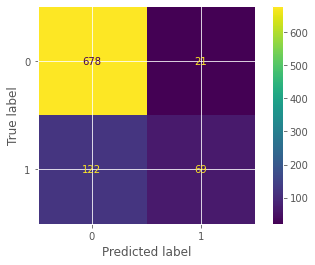

In [ ]:
# Buat confusion matrix untuk hasil prediksi Logistic Regression dgn hyperparameter terbaik menggunakan testing set
cm_test_log = confusion_matrix(y_test,y_pred_test_log, labels=grid_log.best_estimator_.classes_)
disp_test_log = ConfusionMatrixDisplay(confusion_matrix=cm_test_log, display_labels=grid_log.best_estimator_.classes_)

disp_test_log.plot()
plt.show()

Hasil confusion matrix utk testing set:
TP = 60, TN = 678, FP = 21, FN = 122

Hasil classification report utk test set:

In [ ]:
# Tampilkan hasil classification report
print(classification_report(y_test,y_pred_test_log))

              precision    recall  f1-score   support

           0       0.85      0.97      0.90       699
           1       0.77      0.36      0.49       191

    accuracy                           0.84       890
   macro avg       0.81      0.67      0.70       890
weighted avg       0.83      0.84      0.82       890



SUPPORT VECTOR MACHINE

Confusion matrix utk Support Vector Machine pada hasil prediksi training set:

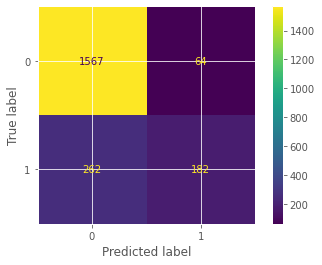

In [ ]:
# Buat confusion matrix untuk hasil prediksi model SVC dgn hyperparameter terbaik menggunakan training set
cm_train_svm = confusion_matrix(y_train,y_pred_train_svm, labels=grid_svm.best_estimator_.classes_)
disp_train_svm = ConfusionMatrixDisplay(confusion_matrix=cm_train_svm, display_labels=grid_svm.best_estimator_.classes_)

disp_train_svm.plot()
plt.show()

Hasil confusion matrix utk training set:
TP = 182, TN = 1567, FP = 64, FN = 262

Hasil classification report utk training set:

In [ ]:
# Tampilkan hasil classification report
print(classification_report(y_train,y_pred_train_svm))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1631
           1       0.74      0.41      0.53       444

    accuracy                           0.84      2075
   macro avg       0.80      0.69      0.72      2075
weighted avg       0.83      0.84      0.82      2075



Confusion matrix utk pada hasil prediksi testing set:

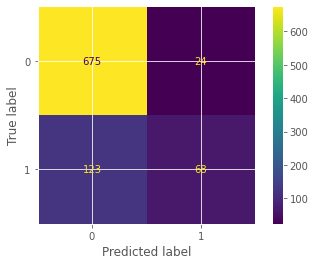

In [ ]:
# Buat confusion matrix untuk hasil prediksi model SVC dgn hyperparameter terbaik menggunakan testing set
cm_test_svm = confusion_matrix(y_test,y_pred_test_svm, labels=grid_svm.best_estimator_.classes_)
disp_test_svm = ConfusionMatrixDisplay(confusion_matrix=cm_test_svm, display_labels=grid_svm.best_estimator_.classes_)

disp_test_svm.plot()
plt.show()

Hasil confusion matrix utk testing set:
TP = 68, TN = 675, FP = 24, FN = 123

Hasil classification report utk testing set:

In [ ]:
# Tampilkan hasil classification report
print(classification_report(y_test,y_pred_test_svm))

              precision    recall  f1-score   support

           0       0.85      0.97      0.90       699
           1       0.74      0.36      0.48       191

    accuracy                           0.83       890
   macro avg       0.79      0.66      0.69       890
weighted avg       0.82      0.83      0.81       890



DECISION TREE

Confusion matrix utk Decision Tree pada hasil prediksi training set:

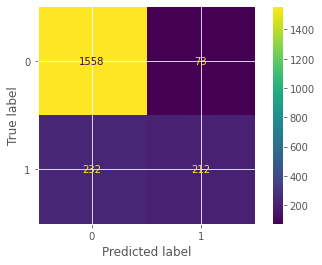

In [ ]:
# Buat confusion matrix untuk hasil prediksi model Decision Tree dgn hyperparameter terbaik menggunakan training set
cm_train_dtc = confusion_matrix(y_train,y_pred_train_dtc, labels=grid_dtc.best_estimator_.classes_)
disp_train_dtc = ConfusionMatrixDisplay(confusion_matrix=cm_train_dtc, display_labels=grid_dtc.best_estimator_.classes_)

disp_train_dtc.plot()
plt.show()

Hasil confusion matrix utk training set:
TP = 212, TN = 1558, FP = 73, FN = 232

Hasil classification report utk training set:

In [ ]:
# Tampilkan hasil classification report
print(classification_report(y_train,y_pred_train_dtc))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1631
           1       0.74      0.48      0.58       444

    accuracy                           0.85      2075
   macro avg       0.81      0.72      0.75      2075
weighted avg       0.84      0.85      0.84      2075



Confusion matrix utk hasil prediksi testing set:

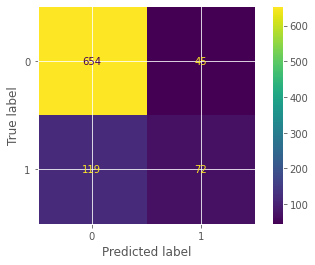

In [ ]:
# Buat confusion matrix untuk hasil prediksi model Decision Tree dgn hyperparameter terbaik menggunakan testing set
cm_test_dtc = confusion_matrix(y_test,y_pred_test_dtc, labels=grid_dtc.best_estimator_.classes_)
disp_test_dtc = ConfusionMatrixDisplay(confusion_matrix=cm_test_dtc, display_labels=grid_dtc.best_estimator_.classes_)

disp_test_dtc.plot()
plt.show()

Hasil confusion matrix utk testing set:
TP = 72, TN = 654, FP = 45, FN = 119

Hasil classification report utk testing set:

In [ ]:
# Tampilkan hasil classification report
print(classification_report(y_test,y_pred_test_dtc))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89       699
           1       0.62      0.38      0.47       191

    accuracy                           0.82       890
   macro avg       0.73      0.66      0.68       890
weighted avg       0.80      0.82      0.80       890



RANDOM FOREST

Confusion matrix utk Random Forest pada hasil prediksi training set:

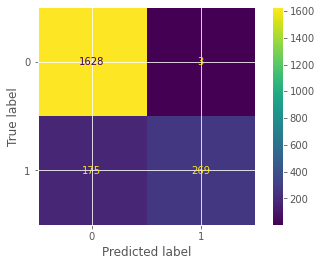

In [ ]:
# Buat confusion matrix untuk hasil prediksi model Random Forest dgn hyperparameter terbaik menggunakan training set
cm_train_rfc = confusion_matrix(y_train,y_pred_train_rfc, labels=grid_rfc.best_estimator_.classes_)
disp_train_rfc = ConfusionMatrixDisplay(confusion_matrix=cm_train_rfc, display_labels=grid_rfc.best_estimator_.classes_)

disp_train_rfc.plot()
plt.show()

Hasil confusion matrix utk training set:
TP = 269, TN = 1628, FP = 3, FN = 175

Hasil classification report utk training set:

In [ ]:
# Tampilkan hasil classification report
print(classification_report(y_train,y_pred_train_rfc))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1631
           1       0.99      0.61      0.75       444

    accuracy                           0.91      2075
   macro avg       0.95      0.80      0.85      2075
weighted avg       0.92      0.91      0.91      2075



Confusion matrix pada hasil prediksi testing set:

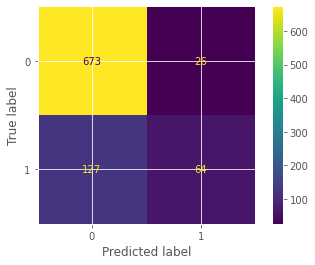

In [ ]:
# Buat confusion matrix untuk hasil prediksi model Random Forest dgn hyperparameter terbaik menggunakan testing set
cm_test_rfc = confusion_matrix(y_test,y_pred_test_rfc, labels=grid_rfc.best_estimator_.classes_)
disp_test_rfc = ConfusionMatrixDisplay(confusion_matrix=cm_test_rfc, display_labels=grid_rfc.best_estimator_.classes_)

disp_test_rfc.plot()
plt.show()

Hasil confusion matrix utk testing set:
TP = 64, TN = 673, FP = 26, FN = 127

Hasil classification report utk testing set:

In [ ]:
# Tampilkan hasil classification report
print(classification_report(y_test,y_pred_test_rfc))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90       699
           1       0.71      0.34      0.46       191

    accuracy                           0.83       890
   macro avg       0.78      0.65      0.68       890
weighted avg       0.81      0.83      0.80       890



K-NEAREST NEIGHBORS

Confusion matrix utk k-Nearest Neighbors pada hasil prediksi training set:

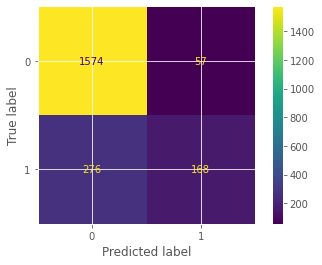

In [ ]:
# Buat confusion matrix untuk hasil prediksi model k-Nearest Neighbors dgn hyperparameter terbaik menggunakan training set
cm_train_knn = confusion_matrix(y_train,y_pred_train_knn, labels=grid_knn.best_estimator_.classes_)
disp_train_knn = ConfusionMatrixDisplay(confusion_matrix=cm_train_knn, display_labels=grid_knn.best_estimator_.classes_)

disp_train_knn.plot()
plt.show()

Hasil confusion matrix utk training set:
TP = 168, TN = 1574, FP = 57, FN = 276

Hasil classification report utk training set:

In [ ]:
# Tampilkan hasil classification report
print(classification_report(y_train,y_pred_train_knn))

              precision    recall  f1-score   support

           0       0.85      0.97      0.90      1631
           1       0.75      0.38      0.50       444

    accuracy                           0.84      2075
   macro avg       0.80      0.67      0.70      2075
weighted avg       0.83      0.84      0.82      2075



Confusion matrix pada hasil prediksi testing set:

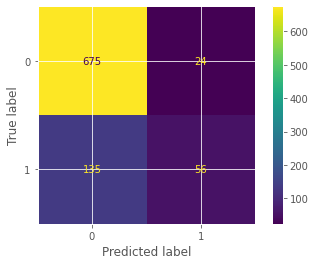

In [ ]:
# Buat confusion matrix untuk hasil prediksi model k-Nearest Neighbors dgn hyperparameter terbaik menggunakan testing set
cm_test_knn = confusion_matrix(y_test,y_pred_test_knn, labels=grid_knn.best_estimator_.classes_)
disp_test_knn = ConfusionMatrixDisplay(confusion_matrix=cm_test_knn, display_labels=grid_knn.best_estimator_.classes_)

disp_test_knn.plot()
plt.show()

Hasil confusion matrix utk testing set:
TP = 56, TN = 675, FP = 24, FN = 135

Hasil classification report utk testing set:

In [ ]:
# Tampilkan hasil classification report
print(classification_report(y_test,y_pred_test_knn))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89       699
           1       0.70      0.29      0.41       191

    accuracy                           0.82       890
   macro avg       0.77      0.63      0.65       890
weighted avg       0.80      0.82      0.79       890



GAUSSIAN NAIVE BAYES

Confusion matrix utk Gaussian Naive Bayes pada hasil prediksi training set:

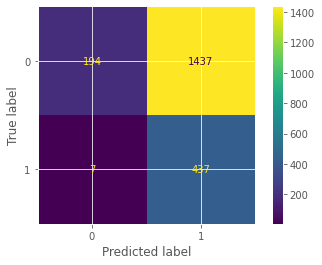

In [ ]:
# Buat confusion matrix untuk hasil prediksi model Gaussian Naive Bayes menggunakan training set
cm_train_gnb = confusion_matrix(y_train,y_pred_train_gnb, labels=gnb_model.classes_)
disp_train_gnb = ConfusionMatrixDisplay(confusion_matrix=cm_train_gnb, display_labels=gnb_model.classes_)

disp_train_gnb.plot()
plt.show()

Hasil confusion matrix utk training set:
TP = 437, TN = 194, FP = 1437, FN = 7

Hasil classification report utk training set:

In [ ]:
# Tampilkan hasil classification report
print(classification_report(y_train,y_pred_train_gnb))

              precision    recall  f1-score   support

           0       0.97      0.12      0.21      1631
           1       0.23      0.98      0.38       444

    accuracy                           0.30      2075
   macro avg       0.60      0.55      0.29      2075
weighted avg       0.81      0.30      0.25      2075



Confusion matrix pada hasil prediksi testing set:

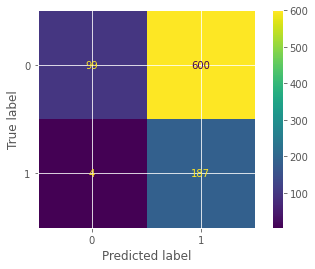

In [ ]:
# Buat confusion matrix untuk hasil prediksi Gaussian Naive Bayes menggunakan testing set
cm_test_gnb = confusion_matrix(y_test,y_pred_test_gnb, labels=gnb_model.classes_)
disp_test_gnb = ConfusionMatrixDisplay(confusion_matrix=cm_test_gnb, display_labels=gnb_model.classes_)

disp_test_gnb.plot()
plt.show()

Hasil confusion matrix utk testing set:
TP = 187, TN = 99, FP = 600, FN = 4

Hasil classification report utk testing set:

In [ ]:
# Tampilkan hasil classification report
print(classification_report(y_test,y_pred_test_gnb))

              precision    recall  f1-score   support

           0       0.96      0.14      0.25       699
           1       0.24      0.98      0.38       191

    accuracy                           0.32       890
   macro avg       0.60      0.56      0.31       890
weighted avg       0.81      0.32      0.28       890



XGBOOST

Confusion matrix utk XGBoost pada hasil prediksi training set:

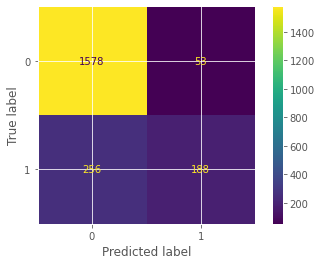

In [ ]:
# Buat confusion matrix untuk hasil prediksi XGBoost dgn hyperparameter terbaik menggunakan training set
cm_train_xbs = confusion_matrix(y_train,y_pred_train_xbs, labels=grid_xbs.best_estimator_.classes_)
disp_train_xbs = ConfusionMatrixDisplay(confusion_matrix=cm_train_xbs, display_labels=grid_xbs.best_estimator_.classes_)

disp_train_xbs.plot()
plt.show()

Hasil confusion matrix utk training set:
TP = 188, TN = 1578, FP = 58, FN = 256

Hasil classification report utk training set:

In [ ]:
# Tampilkan hasil classification report
print(classification_report(y_train,y_pred_train_xbs))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1631
           1       0.78      0.42      0.55       444

    accuracy                           0.85      2075
   macro avg       0.82      0.70      0.73      2075
weighted avg       0.84      0.85      0.83      2075



Confusion matrix pada hasil prediksi testing set:

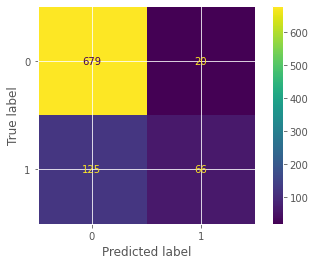

In [ ]:
# Buat confusion matrix untuk hasil prediksi XGBoost dgn hyperparameter terbaik menggunakan testing set
cm_test_xbs = confusion_matrix(y_test,y_pred_test_xbs, labels=grid_xbs.best_estimator_.classes_)
disp_test_xbs = ConfusionMatrixDisplay(confusion_matrix=cm_test_xbs, display_labels=grid_xbs.best_estimator_.classes_)

disp_test_xbs.plot()
plt.show()

Hasil confusion matrix utk training set:
TP = 65, TN = 679, FP = 20, FN = 125

Hasil classification report utk testing set:

In [ ]:
# Tampilkan hasil classification report
print(classification_report(y_test,y_pred_test_xbs))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90       699
           1       0.77      0.35      0.48       191

    accuracy                           0.84       890
   macro avg       0.81      0.66      0.69       890
weighted avg       0.83      0.84      0.81       890



KESIMPULAN CONFUSION MATRIX DAN CLASSIFICATION REPORT PADA DATA TRAINING DAN TESTING SET

Skor recall utk semua model lebih rendah dibandingkan skor precision. Artinya, model jarang memprediksi dgn benar suatu target, namun sekalinya prediksi tsb benar hasilnya terpercaya. Dengan kata lain, porsi false positive (FP) cenderung lbh kecil dibandingkan dgn false negative (FN), membuat prediksi benar (dalam konteks predicted label 0 dan 1) lebih bisa dipercaya. Di sisi lain, f-1 score utk label 0 lbh besar dibandingkan dgn label 1. Artinya, performance model lbh baik dalam memprediksi consumer yg tidak default (0) dibandingkan consumer yg default (1).

Model dgn skor precision terbaik utk training set adalah Random Forest dgn nilai macro-average 0.95. Namun, nilai ini turun drastic menjadi 0.78 ketika diuji pada test set, sehingga menandakan nilai yg tinggi tsb adalah hasil overfitting. Di sisi lain, nilai precision paling stabil adalah pada XGBoost dgn nilai utk training set 0.81 dan testing set 0.82. 

Model dgn skor recall terbaik utk training set adalah Random Forest yaitu 0.8 namun nilai ini juga turun drastic menjadi 0.65. Model dgn skor recall terbaik utk testing set adalah Logistic Regression dgn macro-average 0.67. Namun demikian, angka ini tidak jauh berbeda dgn skor recall model2 lain di test set yg memiliki skor sekitar 0.65-0.67.

Model dgn f-1 score terbaik pada training set adalah Random Forest dgn macro-average 0.85, namun Ketika diuji pada testing set, nilai macro-average turun ke 0.68. Menariknya, model dgn f-1 score terbaik pada test set adalah Logistic Regression dgn nilai macro-average 0.7. Nilai ini juga cenderung stabil krn sama dgn hasil pada training set. Sedangkan, model dgn performa terburuk utk semua kategori adalah Gaussian Naïve Bayes dgn skor hanya sekitar 0.3.


# IX. Model Inference

Kita perlu memastikan model yg telah di-training di training set dan digunakan untuk memprediksi testing set menghasilkan skor performance model yg valid. Untuk itu diperlukan prediksi ulang model thd inference set. Inference set diambil dari dataset fitur original yg telah menjalani feature selection (X_fs). Berdasarkan hasil feature selection sebelumnya, kolom sex dan marital_status tidak berkorelasi dgn target, sehingga akan di-drop dari inference set.

In [ ]:
# Buat dataset inference dari dataset original X. Hapus kolom sex dan marital_status sesuai hasil feature selection sebelumnya
X_fs = X.drop(['sex','marital_status'], axis=1)

In [ ]:
# Lakukan handling outliers utk dataset inference hasil feature selection
windsoriser_inf = Winsorizer(capping_method='iqr', 
                          tail='both', 
                          fold=1.5)

# Fitting winsorizer ke dataset X_fs
windsoriser_inf.fit(X_fs)

# Transformasi dataset X_fs 
X_fs_ho = windsoriser_inf.transform(X_fs)

# Base Model

Kita akan memprediksi base model pada inference set

In [ ]:
y_base_pred_inf_log = base_log.predict(X_fs_ho)

In [ ]:
y_base_pred_inf_svm = base_svm.predict(X_fs_ho)

In [ ]:
y_base_pred_inf_dtc = base_dtc.predict(X_fs_ho)

In [ ]:
y_base_pred_inf_rfc = base_rfc.predict(X_fs_ho)

In [ ]:
y_base_pred_inf_knn = base_knn.predict(X_fs_ho)

In [ ]:
y_base_pred_inf_xbs = base_xbs.predict(X_fs_ho)

In [ ]:
# Tambahkan kolom baru ke tabel summary_table berisi skor hasil prediksi masing2 model inferencepada inference set
summary_table['Accuracy Score (Inference-Base)'] = [accuracy_score(y,y_base_pred_inf_log), accuracy_score(y,y_base_pred_inf_svm),
                                       accuracy_score(y,y_base_pred_inf_dtc), accuracy_score(y,y_base_pred_inf_rfc),
                                      accuracy_score(y,y_base_pred_inf_knn), '',
                                       accuracy_score(y,y_base_pred_inf_xbs)]

# Tuned Model

Berikutnya, kita langsung memprediksi model hasil hyperparameter tuning pada inference set

In [ ]:
# Prediksi nilai target pada inference set menggunakan model Logistic Regression dgn hyperparameter terbaik
y_pred_inf_log = grid_log.best_estimator_.predict(X_fs_ho)

In [ ]:
# Prediksi nilai target pada inference set menggunakan model SVC dgn hyperparameter terbaik
y_pred_inf_svm = grid_svm.best_estimator_.predict(X_fs_ho)

In [ ]:
# Prediksi nilai target pada inference set menggunakan model Decision Tree dgn hyperparameter terbaik
y_pred_inf_dtc = grid_dtc.best_estimator_.predict(X_fs_ho)

In [ ]:
# Prediksi nilai target pada inference set menggunakan model Random Forest dgn hyperparameter terbaik
y_pred_inf_rfc = grid_rfc.best_estimator_.predict(X_fs_ho)

In [ ]:
# Prediksi nilai target pada inference set menggunakan model k-Nearest Neighbors dgn hyperparameter terbaik
y_pred_inf_knn = grid_knn.best_estimator_.predict(X_fs_ho)

In [ ]:
# Prediksi nilai target pada inference set menggunakan model Gaussian Naive Bayes
y_pred_inf_gnb = gnb_model.predict(X_fs_ho)

In [ ]:
# Prediksi nilai target pada inference set menggunakan model XGBoost dgn hyperparameter terbaik
y_pred_inf_xbs = grid_xbs.best_estimator_.predict(X_fs_ho)

Hasil prediksi model pada inference set mempunyai nilai accuracy score. Tambahkan kolom tsb pada summary_table.

In [ ]:
# Tambahkan kolom baru ke tabel summary_table berisi skor hasil prediksi masing2 model tuned pada inference set
summary_table['Accuracy Score (Inference-Tuned)'] = [accuracy_score(y,y_pred_inf_log), accuracy_score(y,y_pred_inf_svm),
                                       accuracy_score(y,y_pred_inf_dtc), accuracy_score(y,y_pred_inf_rfc),
                                      accuracy_score(y,y_pred_inf_knn), accuracy_score(y,y_pred_inf_gnb),
                                       accuracy_score(y,y_pred_inf_xbs)]
# Tampilkan summary_table
summary_table

,Best Hyperparameter,Accuracy Score (Train-Base),Accuracy Score (Test-Base),Accuracy Score (Train-Tuned),Accuracy Score (Test-Tuned),Accuracy Score (Inference-Base),Accuracy Score (Inference-Tuned)
Logistic Regression,"max_iter=1000,penalty=l2",0.836145,0.839326,0.836145,0.839326,0.837437,0.837437
SVM,"C=1, gamma=0.1, kernel=rbf",0.849639,0.835955,0.842892,0.834831,0.845531,0.840472
Decision Tree,"criterion=entropy, max_depth=5",0.999518,0.999518,0.853012,0.815730,0.915008,0.839460
Random Forest,"criterion=gini, max_depth=10, n_estimators=100",0.999518,0.829213,0.914217,0.828090,0.944351,0.887690
K-Nearest Neighbors,n_neighbors=14,0.85494,0.821348,0.839518,0.821348,0.844519,0.834064
Gaussian Naive Bayes,,,,0.304096,0.321348,,0.308263
XGBoost,"learning_rate=0.1, max_depth=2",0.873735,0.840449,0.851084,0.837079,0.861383,0.846206


Secara keseluruhan, skor akurasi base model dan tuned model cukup robust ketika model diaplikasikan pada inference set. Performance sangat baik ditunjukkan oleh model Random Forest dgn accuracy model base hasil inference 0.94 dan accuracy model tuned hasil inference 0.88. Dengan hasil ini, berdasarkan accuracy score model Random Forest tanpa hyperparameter tuning merupakan model terbaik dari seluruh kategori.

Berikutnya kita akan menganalisa confusion matrix dan classification report untuk mengetahui skor precision, recall dan f-1 score.

LOGISTIC REGRESSION

Confusion matrix utk model Logistic Regression pada hasil prediksi inference set:

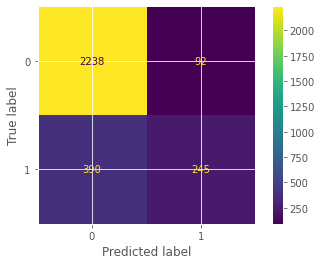

In [ ]:
# Buat confusion matrix untuk hasil prediksi model Logistic Regression menggunakan inference set
cm_inf_log = confusion_matrix(y,y_pred_inf_log, labels=grid_log.best_estimator_.classes_)
disp_inf_log = ConfusionMatrixDisplay(confusion_matrix=cm_inf_log, display_labels=grid_log.best_estimator_.classes_)

disp_inf_log.plot()
plt.show()

Hasil confusion matrix utk inference set:
TP = 245, TN = 2238, FP = 92, FN = 390

Hasil classification report utk inference set:

In [ ]:
# Tampilkan classification report
print(classification_report(y,y_pred_inf_log))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      2330
           1       0.73      0.39      0.50       635

    accuracy                           0.84      2965
   macro avg       0.79      0.67      0.70      2965
weighted avg       0.82      0.84      0.82      2965



SUPPORT VECTOR MACHINE

Confusion matrix utk model SVC pada hasil prediksi inference set:

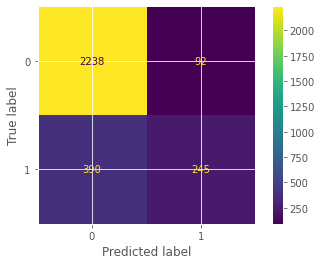

In [ ]:
# Buat confusion matrix untuk hasil prediksi model SVC menggunakan inference set
cm_inf_svm = confusion_matrix(y,y_pred_inf_svm, labels=grid_svm.best_estimator_.classes_)
disp_inf_svm = ConfusionMatrixDisplay(confusion_matrix=cm_inf_log, display_labels=grid_svm.best_estimator_.classes_)

disp_inf_svm.plot()
plt.show()

Hasil confusion matrix utk inference set:
TP = 245, TN = 2238, FP = 92, FN = 390

Hasil classification report utk inference set:

In [ ]:
# Tampilkan classification report
print(classification_report(y,y_pred_inf_svm))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      2330
           1       0.74      0.39      0.51       635

    accuracy                           0.84      2965
   macro avg       0.80      0.68      0.71      2965
weighted avg       0.83      0.84      0.82      2965



DECISION TREE

Confusion matrix utk model Decision Tree pada hasil prediksi inference set:

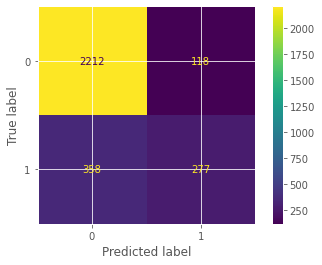

In [ ]:
# Buat confusion matrix untuk hasil prediksi model Decision Tree menggunakan inference set
cm_inf_dtc = confusion_matrix(y,y_pred_inf_dtc, labels=grid_dtc.best_estimator_.classes_)
disp_inf_dtc = ConfusionMatrixDisplay(confusion_matrix=cm_inf_dtc, display_labels=grid_dtc.best_estimator_.classes_)

disp_inf_dtc.plot()
plt.show()

Hasil confusion matrix utk inference set:
TP = 277, TN = 2212, FP = 118, FN = 358

Hasil classification report utk inference set:

In [ ]:
# Tampilkan classification report
print(classification_report(y,y_pred_inf_dtc))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      2330
           1       0.70      0.44      0.54       635

    accuracy                           0.84      2965
   macro avg       0.78      0.69      0.72      2965
weighted avg       0.83      0.84      0.82      2965



RANDOM FOREST

Confusion matrix utk model Random Forest pada hasil prediksi inference set:

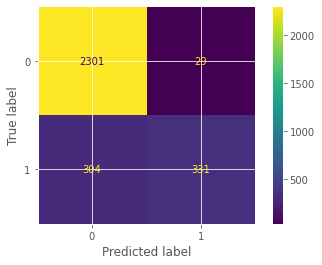

In [ ]:
# Buat confusion matrix untuk hasil prediksi model Random Forest menggunakan inference set
cm_inf_rfc = confusion_matrix(y,y_pred_inf_rfc, labels=grid_rfc.best_estimator_.classes_)
disp_inf_rfc = ConfusionMatrixDisplay(confusion_matrix=cm_inf_rfc, display_labels=grid_rfc.best_estimator_.classes_)

disp_inf_rfc.plot()
plt.show()

Hasil confusion matrix utk inference set:
TP = 331, TN = 2301 FP = 29, FN = 304

Hasil classification report utk inference set:

In [ ]:
# Tampilkan classification report
print(classification_report(y,y_pred_inf_rfc))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2330
           1       0.92      0.52      0.67       635

    accuracy                           0.89      2965
   macro avg       0.90      0.75      0.80      2965
weighted avg       0.89      0.89      0.88      2965



K-NEAREST NEIGHBORS

Confusion matrix utk model k-Nearest Neighbors pada hasil prediksi inference set:

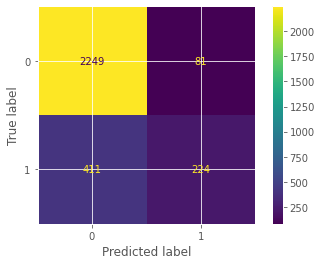

In [ ]:
# Buat confusion matrix untuk hasil prediksi model k-Nearest Neighbors menggunakan inference set
cm_inf_knn = confusion_matrix(y,y_pred_inf_knn, labels=grid_knn.best_estimator_.classes_)
disp_inf_knn = ConfusionMatrixDisplay(confusion_matrix=cm_inf_knn, display_labels=grid_knn.best_estimator_.classes_)

disp_inf_knn.plot()
plt.show()

Hasil confusion matrix utk inference set:
TP = 224, TN = 2249, FP = 81, FN = 411

Hasil classification report utk inference set:

In [ ]:
# Tampilkan classification report
print(classification_report(y,y_pred_inf_knn))

              precision    recall  f1-score   support

           0       0.85      0.97      0.90      2330
           1       0.73      0.35      0.48       635

    accuracy                           0.83      2965
   macro avg       0.79      0.66      0.69      2965
weighted avg       0.82      0.83      0.81      2965



GAUSSIAN NAIVE BAYES

Confusion matrix utk model Gaussian Naive Bayes pada hasil prediksi inference set:

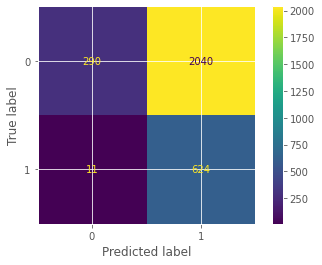

In [ ]:
# Buat confusion matrix untuk hasil prediksi model Gaussian Naive Bayes menggunakan inference set
cm_inf_gnb = confusion_matrix(y,y_pred_inf_gnb, labels=gnb_model.classes_)
disp_inf_gnb = ConfusionMatrixDisplay(confusion_matrix=cm_inf_gnb, display_labels=gnb_model.classes_)

disp_inf_gnb.plot()
plt.show()

Hasil confusion matrix utk inference set:
TP = 624, TN = 290, FP = 2040, FN = 11

Hasil classification report utk inference set:

In [ ]:
# Tampilkan classification report
print(classification_report(y,y_pred_inf_gnb))

              precision    recall  f1-score   support

           0       0.96      0.12      0.22      2330
           1       0.23      0.98      0.38       635

    accuracy                           0.31      2965
   macro avg       0.60      0.55      0.30      2965
weighted avg       0.81      0.31      0.25      2965



XGBOOST

Confusion matrix utk model XGBoost pada hasil prediksi inference set:

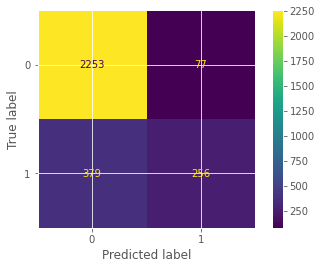

In [ ]:
# Buat confusion matrix untuk hasil prediksi model XGBoost menggunakan inference set
cm_inf_xbs = confusion_matrix(y,y_pred_inf_xbs, labels=grid_xbs.best_estimator_.classes_)
disp_inf_xbs = ConfusionMatrixDisplay(confusion_matrix=cm_inf_xbs, display_labels=grid_xbs.best_estimator_.classes_)

disp_inf_xbs.plot()
plt.show()

Hasil confusion matrix utk inference set:
TP = 256, TN = 2253, FP = 77, FN = 379

Hasil classification report utk inference set:

In [ ]:
# Tampilkan classification report
print(classification_report(y,y_pred_inf_xbs))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      2330
           1       0.77      0.40      0.53       635

    accuracy                           0.85      2965
   macro avg       0.81      0.69      0.72      2965
weighted avg       0.84      0.85      0.83      2965



KESIMPULAN CONFUSION MATRIX DAN CLASSIFICATION REPORT PADA DATA INFERENCE SET

Secara keseluruhan, nilai precision, recall dan f-1 hasil model inference tidak jauh beda dengan hasil training dan testing set. Model Random Forest menjadi model terbaik dalam kategori Precision dan f-1 score.

# X. Kesimpulan

Performance model sudah cukup baik pada training dan testing set secara keseluruhan dgn skor akurasi > 0.8, kecuali Gaussian Naïve Bayes (GNB) dimana hanya mempunyai skor akurasi ~0.3. Buruknya performa GNB bisa dikarenakan bbrp factor: GNB mengasumsikan setiap kelas memiliki distribusi Gaussian dimana distribusi sebenarnya adalah skewed. Selain itu, GNB lebih cocok diterapkan pada data continuous (numerik), sedangkan beberapa kolom pada dataset ini berisi data kategorikal. Ditambah lagi, GNB tidak menjalani cross-validation dan tidak terdapat hyperparameter utk di-tuning. 

Secara keseluruhan, base model memiliki skor akurasi lbh baik dibandingkan model dgn hyperparameter tuning, kecuali untuk Logistic Regression dan SVM dimana performance kedua model kurang lebih sama. Kondisi overfitting juga terlihat dari table secara keseluruhan karena skor akurasi pada testing set lebih rendah dibanding pada training set pada base model dan tuned model. Sementara itu, base model dgn skor akurasi terbaik adalah Decision Tree dgn skor hampir sempurna (0.99). 


Berdasarkan classification report, skor recall utk semua model lebih rendah dibandingkan skor precision. Artinya, model jarang memprediksi dgn benar suatu target, namun sekalinya prediksi tsb benar hasilnya terpercaya. Dengan kata lain, porsi false positive (FP) cenderung lbh kecil dibandingkan dgn false negative (FN), membuat prediksi benar (dalam konteks predicted label 0 dan 1) lebih bisa dipercaya. Di sisi lain, f-1 score utk label 0 lbh besar dibandingkan dgn label 1. Artinya, performance model lbh baik dalam memprediksi consumer yg tidak default (0) dibandingkan consumer yg default (1).

Model dgn skor precision terbaik utk training set adalah Random Forest dgn nilai macro-average 0.95. Namun, nilai ini turun drastic menjadi 0.78 ketika diuji pada test set, sehingga menandakan nilai yg tinggi tsb dipengaruhi oleh overfitting. Meskipun demikian, nilai ini tidaklah jauh dari nilai precision pada model lain pada test set, dimana nilai terbaik hanya mencapai 0.81. Di sisi lain, nilai precision paling stabil adalah pada XGBoost dgn nilai utk training set 0.81 dan testing set 0.82. 

Model dgn skor recall terbaik utk training set adalah Random Forest yaitu 0.8 namun nilai ini juga turun drastic menjadi 0.65. Model dgn skor recall terbaik utk testing set adalah Logistic Regression dgn macro-average 0.67. Namun demikian, angka ini tidak jauh berbeda dgn skor recall model2 lain di test set yg memiliki skor sekitar 0.65-0.67.

Model dgn f-1 score terbaik pada training set adalah Random Forest dgn macro-average 0.85, namun Ketika diuji pada testing set, nilai macro-average turun ke 0.68. Menariknya, model dgn f-1 score terbaik pada test set adalah Logistic Regression dgn nilai macro-average 0.7. Nilai ini juga cenderung stabil krn sama dgn hasil pada training set. Sedangkan, model dgn performa terburuk utk semua kategori adalah Gaussian Naïve Bayes dgn skor hanya sekitar 0.3.

Secara keseluruhan, seluruh metrics untuk model performance (accuracy score, precision, recall dan f-1 score) cukup robust ketika model diaplikasikan pada inference set. Performance sangat baik ditunjukkan oleh model Random Forest dgn accuracy model base hasil inference 0.94 dan accuracy model tuned hasil inference 0.88. Dengan hasil ini, berdasarkan accuracy score model Random Forest tanpa hyperparameter tuning merupakan model terbaik dari seluruh kategori.

Setelah mempertimbangkan berbagai factor diatas, model Random Forest tanpa hyperparameter tuning dinyatakan sebagai model terbaik untuk diaplikasikan sebagai algoritma utk memprediksi kemungkinan default user kartu kredit pada dataset credit_card_default.csv. Model ini mempunyai tingkat accuracy score dan precision sangat baik (> 0.9) dan f-1 score yg baik (> 0.8). Kelemahan dari model ini adalah adanya overfitting pada training set. Namun, ketika diuji pada test dan inference set, performa model ini masih sangat baik. Kekurangan lainnya adalah model ini mempunyai skor recall cukup rendah (< 0.7). Namun untuk kasus spesifik seperti memprediksi kemungkinan default pada kartu kredit, skor precision lebih tepat dijadikan acuan dibandingkan skor recall dalam menilai performance model. Mengapa? Karena kesalahan dalam memprediksi bangkrut user yg ternyata tidak bangkrut, lebih dihindari daripada kesalahan dalam memprediksi tidak bangkrut user yg ternyata bangkrut. Pada kasus pertama, kesalahan dapat mengurangi profit margin dari penyedia kartu kredit, tetapi dampak tsb masih minimal. Pada kasus kedua, kesalahan dapat mengakibatkan perusahaan menolak calon2 konsumen yg sebenarnya layak mendapat jasa kartu kredit.  Akibatnya, perusahaan dapat kalah bersaing dgn perusahaan lain yg lbh longgar dalam syarat memberikan kredit pada konsumen2 yg membutuhkan. Oleh karena itu, model Random Forest tanpa hyperparameter tuning (pakai parameter default) direkomendasikan untuk penggunaan credit card default prediction di masa depan.


# Pertanyaan

1. Apakah fungsi parameter criterion pada Decision Tree? Jelaskan salah satu criterion yang kalian pahami!

Parameter criterion pada Decision Tree adalah metode yg digunakan oleh pohon utk menentukan fitur utk root dan fitur saat melakukan splitting node. Criterion dibagi menjadi gini dan entropy. Gini adalah probability untuk melakukan salah klasifikasi label pada suatu fitur jika sampel diambil secara acak. Criterion gini pada Decision Tree berarti pohon akan mencari fitur dgn gini index terendah utk dijadikan node. Sedangkan entropy adalah tingkat keacakan data. Semakin data teracak maka semakin tinggi entropy. Pada criterion entropy, pohon akan mencari fitur dgn information gain terbesar (dihitung dari selisih entropi) untuk dijadikan node.

2. Apakah fungsi dari pruning pada Tree model?

Pruning adalah membatasi ukuran pohon pada Decision Tree atau model2 turunannya dgn cara meniadakan bagian pohon yg tidak critical sehingga algoritma berjalan lebih efisien

3. Bagaimana cara memilih K yang optimal pada KNN?

Nilai k yg optimal dari KNN adalah jarak terdekat antara data point tetangga dgn data point baru yg ditambahkan. Jarak tsb bisa dicari menggunakan Manhattan, Euclidean atau Minkowski distance. Manhattan distance adalah menggunakan penjumlahan dari nilai absolut dari setiap koordinat jarak antar titik. Euclidean distance menggunakan akar penjumlahan nilai kuadrat dari setiap koordinat jarak antar titik. Sedangkan Minkowski distance menggunakan akar bilangan n dari penjumlahan nilai yg dipangkatkan n dari setiap koordinat jarak antar titik. Euclidean distance adalah default pada model sklearn krn paling sering digunakan. Sedangkan jumlah k dari KNN menunjukkan jumlah tetangga yg digunakan utk menarik decision boundary utk melakukan klasifikasi pada target. Jumlah tetangga yg optimal dapat dicari menggunakan hyperparameter tuning spt grid search atau random search, yg akan meng-compare performance masing2 model dgn k_neighbors yg berbeda2.

4. Jelaskan apa yang kalian ketahui tentang Cross Validation!

Cross-validation adalah melakukan resampling dari data training utk membaginya menjadi bbrp fold utk dilakukan training set baru dan validation set. Misalnya kita atur cv=5, maka training set akan dibagi menjadi 5 fold dgn training set baru masing2 fold sebesar 4/5 dari fold dan validation set masing2 fold sebesar 1/5  dari fold. Resampling tsb dilakukan secara acak. Kemudian model akan di-training pada masing2 training set baru dan gunakan utk memprediksi validation set utk diperoleh performance dari model2 tsb. Kemudian performance dari model2 tsb akan dirata2kan untuk mencari rata2 validation score. Validation score tsb akan dibandingkan dgn model yg di-training di training set asal dan diuji di testing set untuk mendeteksi adanya overfitting.

5. Jelaskan apa yang kalian ketahui tentang Accuracy, Precision, Recall, F1 Score!
Precision adalah jumlah true positive (TP) dibagi dengan jumlah TP dan false positive (FP). Precision menentukan tingkat akurasi prediksi dari model, diukur dari perbandingan antara prediksi benar yg sesuai dgn data benar dan total prediksi benar yg telah dilakukan.

Precision=  TP/(TP+FP)

Recall adalah jumlah TP dibagi dengan jumlah TP dan false negative (FN). Recall menentukan
tingkat akurasi prediksi dari model, diukur dari perbandingan antara prediksi benar yg sesuai dgn data benar dan total data benar yg ada.

Recall=  TP/(TP+FN)

Accuracy adalah total jumlah prediksi benar dan salah yg sesuai dengan data dibagi dengan total jumlah prediksi yg telah dilakukan.

Accuracy=  (TP+TN)/(TP+TN+FP+FN)

F-1 score adalah jumlah prediksi benar yg sesuai dgn data benar, dibagi dengan jumlah prediksi benar yg sesuai ditambah dengan rata2 dari prediksi yg salah. F-1 score merupakan metrik utk mengukur tingkat akurasi model dlm memprediksi benar dgn mempertimbangkan juga antara kesalahan prediksi benar dan kesalahan prediksi salah. 

F1 Score=  TP/(TP+0.5*(FP+FN))

